In [1]:
# Import Libraries and Setup Directories
# Standard Library
import os
import pickle
import datetime as dt
import subprocess
import sys
import logging
import warnings

# Data Handling and Numerical Computing
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Machine Learning and Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Input, LSTM, Dense, Dropout, Input, LayerNormalization, BatchNormalization

# Financial Data
import yfinance as yf
import pandas_datareader as web

warnings.filterwarnings('ignore')

# Ensure necessary directories exist
DATA_DIR = "data"
MODEL_DIR = "models"
for directory in [DATA_DIR, MODEL_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

# Install plotly if not already installed
def install_package(package):
    try:
        __import__(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")

install_package('plotly')
print("✅ All required packages are ready!")

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'{DATA_DIR}/stock_prediction.log'),
        logging.StreamHandler()
    ]
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Add error handling wrapper
def safe_execute(func, *args, **kwargs):
    """Safely execute functions with error handling"""
    try:
        return func(*args, **kwargs)
    except Exception as e:
        logging.error(f"Error in {func.__name__}: {str(e)}")
        raise

Created directory: data
Created directory: models
✅ plotly is already installed
✅ All required packages are ready!


In [2]:
# Ensure the necessary directories exist
DATA_DIR = "data"  # Directory to save the data
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
# Define constants outside the loop
COMPANY = 'CBA.AX'
DEFAULT_TRAIN_START = '2020-01-01'
DEFAULT_TRAIN_END = '2023-01-01'
while True:
    try:
        # Get training start date
        TRAIN_START = input(f"Enter training start date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_START}': ")
        if not TRAIN_START.strip():
            TRAIN_START = DEFAULT_TRAIN_START
        
        # Get training end date
        TRAIN_END = input(f"Enter training end date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_END}': ")
        if not TRAIN_END.strip():
            TRAIN_END = DEFAULT_TRAIN_END
        
        # Validate date format
        start_date = dt.datetime.strptime(TRAIN_START, '%Y-%m-%d')
        end_date = dt.datetime.strptime(TRAIN_END, '%Y-%m-%d')
        
        # Validate date range
        if start_date >= end_date:
            print("Error: Training end date must be after training start date.")
            continue
        
        print(f"Using training period: {TRAIN_START} to {TRAIN_END}")
        break  # Exit the loop if everything is valid
    
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD format.")
        print(f"Using default values: {DEFAULT_TRAIN_START} to {DEFAULT_TRAIN_END}")
        TRAIN_START = DEFAULT_TRAIN_START
        TRAIN_END = DEFAULT_TRAIN_END
        break  # Or continue to ask again by removing this line

# Get the data for the stock AAPL
data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
data_filename = f"{DATA_DIR}/{COMPANY}_data.csv"


# If it does not exist, save the data to the file
print(f"Saving data to {data_filename}")
data.to_csv(data_filename)
print(f"Data saved to {data_filename}")

df = pd.read_csv(data_filename, skiprows=[1,2])

# Preprocess the data
# Check for missing values and handle them properly
print("\nMissing values check:")
print(df.isnull().sum())

# Handle missing values with forward fill or interpolation
df = df.fillna(method='ffill').fillna(method='bfill')

# The columns actually contain: Date, Price, Close, High, Low, Volume
df.columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Volume']

# Add after your feature columns definition
def create_technical_indicators(df):
    """Add technical indicators as features"""
    # Moving averages
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_upper'] = df['MA_20'] + (df['Close'].rolling(window=20).std() * 2)
    df['BB_lower'] = df['MA_20'] - (df['Close'].rolling(window=20).std() * 2)
    
    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    
    # Volatility
    df['Volatility'] = df['Close'].rolling(window=20).std()
    
    return df.dropna()

df = create_technical_indicators(df)
    
# Save new cleaned data to a CSV file
cleaned_data_filename = f"{DATA_DIR}/{COMPANY}_cleaned_data.csv"
df.to_csv(cleaned_data_filename, index=False)
print(f"Cleaned data saved to {cleaned_data_filename}")

# Check few rows of the cleaned data
print("Cleaned Data Sample:")
print(df.head())

Using training period: 2020-01-01 to 2023-01-01


[*********************100%***********************]  1 of 1 completed

Saving data to data/CBA.AX_data.csv
Data saved to data/CBA.AX_data.csv

Missing values check:
Price     0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Cleaned data saved to data/CBA.AX_cleaned_data.csv
Cleaned Data Sample:
          Date      Price      Close       High        Low    Volume  \
49  2020-03-12  52.463734  57.143985  52.463734  56.445691  10247518   
50  2020-03-13  55.165474  55.165474  47.517457  50.269081  17021972   
51  2020-03-16  49.645603  54.350793  49.645603  51.075448  10752353   
52  2020-03-17  56.229542  56.445683  49.628973  49.645599  11345264   
53  2020-03-18  53.162022  55.614375  51.507721  54.832945  10404325   

         MA_5      MA_20      MA_50        RSI   BB_upper   BB_lower  \
49  60.364463  68.302137  68.318266  10.666663  79.383720  57.220553   
50  58.844835  67.359748  68.117381  10.048021  79.546887  55.172609   
51  57.750835  66.383534  67.884433   9.948786  79.468068  53.299000   
52  56.841386  65.537264  67

In [3]:
# Data Splitting
# Define splitting functions
def split_by_ratio_sequential(df, test_size_ratio):
    """Split data sequentially based on a ratio."""
    split_index = int(len(df) * (1 - test_size_ratio))
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

def split_by_date(df, cutoff_date):
    """Split data based on a specific cutoff date."""
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['Date'] < cutoff_date]
    test_data = df[df['Date'] >= cutoff_date]
    return train_data, test_data

def split_by_ratio_random(df, test_size_ratio):
    """Split data randomly based on a ratio."""
    train_data, test_data = train_test_split(df, test_size=test_size_ratio, random_state=42, shuffle=True)
    return train_data, test_data

# Load cleaned data
df = pd.read_csv(cleaned_data_filename)
df['Date'] = pd.to_datetime(df['Date'])

# Get user input for splitting method
while True:
    print("\nChoose a data splitting method:")
    print("1. Sequential split by ratio")
    print("2. Split by date")
    print("3. Random split by ratio")
    choice = input("Enter your choice (1/2/3): ").strip()
    
    if choice == '1':
        ratio = input("Enter test size ratio (e.g., 0.2 for 20%): ").strip()
        test_ratio = float(ratio) if ratio and 0 < float(ratio) < 1 else 0.2
        train_data, test_data = split_by_ratio_sequential(df, test_ratio)
        print(f"Data split sequentially with {test_ratio*100}% for testing.")
        break
    elif choice == '2':
        cutoff_date = input("Enter cutoff date (YYYY-MM-DD): ").strip()
        train_data, test_data = split_by_date(df, cutoff_date)
        print(f"Data split by date with cutoff at {cutoff_date}.")
        break
    elif choice == '3':
        ratio = input("Enter test size ratio (e.g., 0.2 for 20%): ").strip()
        test_ratio = float(ratio) if ratio and 0 < float(ratio) < 1 else 0.2
        train_data, test_data = split_by_ratio_random(df, test_ratio)
        print(f"Data split randomly with {test_ratio*100}% for testing.")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")

# Print shapes
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Choose a data splitting method:
1. Sequential split by ratio
2. Split by date
3. Random split by ratio
Data split sequentially with 20.0% for testing.
Train data shape: (568, 14)
Test data shape: (143, 14)


In [4]:
# Data Scaling
# Define feature columns
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Initialize dictionaries for scaled data
scalers = {}
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

# Scale features
print("Scaling feature columns...")
for column in feature_columns:
    if column in train_data.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train_data[column] = scaler.fit_transform(train_data[[column]])
        scaled_test_data[column] = scaler.transform(test_data[[column]])
        scalers[column] = scaler
        print(f"Scaled column: {column}")
        print(f"  Original range: [{train_data[column].min():.4f}, {train_data[column].max():.4f}]")
        print(f"  Scaled range: [{scaled_train_data[column].min():.4f}, {scaled_train_data[column].max():.4f}]")

# Save scalers
scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)
print(f"\nScalers saved to {scalers_filename}")

# Scaling summary
print(f"\nScaling Summary:")
print(f"Number of features scaled: {len(scalers)}")
print(f"Scaled features: {list(scalers.keys())}")
print(f"Train data shape after scaling: {scaled_train_data.shape}")
print(f"Test data shape after scaling: {scaled_test_data.shape}")

# Display sample data
print("\nSample of scaled training data:")
print(scaled_train_data.head())
print("\nSample of scaled test data:")
print(scaled_test_data.head())

Scaling feature columns...
Scaled column: Close
  Original range: [48.0495, 96.5344]
  Scaled range: [0.0000, 1.0000]
Scaled column: High
  Original range: [44.4250, 95.6616]
  Scaled range: [0.0000, 1.0000]
Scaled column: Low
  Original range: [46.5615, 96.2451]
  Scaled range: [0.0000, 1.0000]
Scaled column: Volume
  Original range: [350619.0000, 17021972.0000]
  Scaled range: [0.0000, 1.0000]

Scalers saved to data/CBA.AX_scalers.pkl

Scaling Summary:
Number of features scaled: 4
Scaled features: ['Close', 'High', 'Low', 'Volume']
Train data shape after scaling: (568, 14)
Test data shape after scaling: (143, 14)

Sample of scaled training data:
        Date      Price     Close      High       Low    Volume       MA_5  \
0 2020-03-12  52.463734  0.187574  0.156894  0.198944  0.593647  60.364463   
1 2020-03-13  55.165474  0.146767  0.060356  0.074625  1.000000  58.844835   
2 2020-03-16  49.645603  0.129964  0.101892  0.090855  0.623929  57.750835   
3 2020-03-17  56.229542  0.17317

In [5]:
# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Original

# --- Prerequisite Check ---
# Ensure the necessary scaled data from the previous steps is available.
print("Checking for prerequisite data...")
scaled_train_data
scaled_test_data
print("✅ Found 'scaled_train_data' and 'scaled_test_data'.")

# --- Data Preparation for Models ---
# This part of the code prepares the data in the sequence format required by recurrent models.
# Correct feature columns based on the cleaning step. 
# The available numeric columns after cleaning are ['Price', 'Close', 'High', 'Low', 'Volume']
# We will predict 'Close' price, and use others as features.
# Let's define the columns we will use for training. 'Close' must be the first one.
feature_columns = ['Close', 'High', 'Low', 'Price', 'Volume']

# Select and convert data to numpy arrays
train_values = scaled_train_data[feature_columns].values
test_values = scaled_test_data[feature_columns].values

# Function to create sequences
def create_sequences(data, look_back):
    """Creates sequences and corresponding labels for time series forecasting."""
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :]) # Sequence of 'look_back' days
        y.append(data[i, 0]) # The 'Close' price of the next day
    return np.array(X), np.array(y)

# Create training and testing sequences
X_train, y_train = create_sequences(train_values, PREDICTION_DAYS)
X_test, y_test = create_sequences(test_values, PREDICTION_DAYS)

print("\n--- Data Shapes for Modeling ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("---------------------------------")

# Add after your data preparation
from sklearn.model_selection import TimeSeriesSplit

def time_series_cross_validation(X, y, model_builder, n_splits=5):
    """Perform time series cross-validation"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Training fold {fold + 1}/{n_splits}")
        
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        model = model_builder()
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        
        val_pred = model.predict(X_val_fold, verbose=0)
        val_mae = mean_absolute_error(y_val_fold, val_pred)
        scores.append(val_mae)
        
        print(f"Fold {fold + 1} MAE: {val_mae:.6f}")
    
    return np.mean(scores), np.std(scores)

# Function to create the dataset with lookback
def create_dataset(data, look_back=1):
    """Create dataset with lookback feature"""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Assuming the first column is the target
    return np.array(X), np.array(y)

# Build model function
def build_improved_model(input_shape, model_type='lstm', use_attention=False):
    """Build improved model with better architecture"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    if model_type.lower() == 'lstm':
        model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    elif model_type.lower() == 'gru':
        model.add(GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    elif model_type.lower() == 'rnn':
        model.add(SimpleRNN(128, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(64, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(32, return_sequences=False, dropout=0.2))
    else:
        raise ValueError("Unsupported model type. Choose 'lstm', 'gru', or 'rnn'.")
    
    # Add batch normalization
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    # Use better optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
    
    return model

Checking for prerequisite data...
✅ Found 'scaled_train_data' and 'scaled_test_data'.

--- Data Shapes for Modeling ---
X_train shape: (508, 60, 5)
y_train shape: (508,)
X_test shape: (83, 60, 5)
y_test shape: (83,)
---------------------------------


In [6]:
# Build model frame
def build_model(input_shape, layers_config):
    """Build model based on configuration"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for layer_config in layers_config:
        if layer_config['type'] == 'lstm':
            model.add(LSTM(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'gru':
            model.add(GRU(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'rnn':
            model.add(SimpleRNN(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'dropout':
            model.add(Dropout(layer_config['rate']))
        elif layer_config['type'] == 'dense':
            model.add(Dense(
                layer_config['units'],
                activation=layer_config.get('activation', 'linear'),
                name=layer_config.get('name')
            ))
    
    # Add final output layer if not present
    if layers_config[-1]['type'] != 'dense' or layers_config[-1]['units'] != 1:
        model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [7]:
# Train LSTM Model
print("===== Training LSTM Model =====")
lstm_layers = [
    {'type': 'lstm', 'units': 100, 'return_sequences': True, 'name': 'lstm_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'lstm', 'units': 50, 'return_sequences': False, 'name': 'lstm_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_1'}
]

epochs = 50
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_lstm_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

lstm_model = build_model(input_shape, lstm_layers)
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print("\n--- LSTM Model Evaluation ---")
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("==============================")

===== Training LSTM Model =====
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2558 - mae: 0.4181 - val_loss: 0.0893 - val_mae: 0.2856
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0587 - mae: 0.1997 - val_loss: 0.0058 - val_mae: 0.0629
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0280 - mae: 0.1342 - val_loss: 0.0115 - val_mae: 0.0904
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0183 - mae: 0.1073 - val_loss: 0.0050 - val_mae: 0.0624
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0181 - mae: 0.1079 - val_loss: 0.0276 - val_mae: 0.1550
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0163 - mae: 0.1034 - val_loss: 0.0051 - val_mae: 0.0636
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0111 - mae: 0.0842 - val_loss: 0.0070 - val_mae: 0.0717
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0093 - mae: 0.0761 - val_loss: 0.0065 - val_mae: 0.0688
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━

In [8]:
# Train GRU Model
print("===== Training GRU Model =====")
gru_layers = [
    {'type': 'gru', 'units': 100, 'return_sequences': True, 'name': 'gru_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'gru', 'units': 50, 'return_sequences': False, 'name': 'gru_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_100'}
]

epochs = 50
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_gru_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_model(input_shape, gru_layers)
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = gru_model.evaluate(X_test, y_test, verbose=0)
print("\n--- GRU Model Evaluation ---")
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("=============================")

===== Training GRU Model =====
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 1.0142 - mae: 0.8317 - val_loss: 0.0387 - val_mae: 0.1750
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0763 - mae: 0.2334 - val_loss: 0.0098 - val_mae: 0.0869
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0356 - mae: 0.1529 - val_loss: 0.0052 - val_mae: 0.0564
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0278 - mae: 0.1355 - val_loss: 0.0072 - val_mae: 0.0659
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0266 - mae: 0.1281 - val_loss: 0.0067 - val_mae: 0.0638
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0243 - mae: 0.1249 - val_loss: 0.0048 - val_mae: 0.0543
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0192 - mae: 0.1096 - val_loss: 0.0062 - val_mae: 0.0613
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0155 - mae: 0.0986 - val_loss: 0.0032 - val_mae: 0.0492
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━

In [9]:
# Train RNN Model
print("===== Training Simple RNN Model =====")
rnn_layers = [
    {'type': 'rnn', 'units': 128, 'return_sequences': True, 'name': 'rnn_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'rnn', 'units': 64, 'return_sequences': True, 'name': 'rnn_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'rnn', 'units': 32, 'return_sequences': False, 'name': 'rnn_3'},
    {'type': 'dropout', 'rate': 0.3},
    {'type': 'dense', 'units': 50, 'activation': 'relu', 'name': 'dense_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_2'},
    {'type': 'dense', 'units': 1, 'activation': 'linear', 'name': 'output'}
]

epochs = 75
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_rnn_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

rnn_model = build_model(input_shape, rnn_layers)
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print("\n--- Simple RNN Model Evaluation ---")
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("==================================")

===== Training Simple RNN Model =====
Epoch 1/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.3169 - mae: 0.4484 - val_loss: 0.1768 - val_mae: 0.4094
Epoch 2/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1294 - mae: 0.2914 - val_loss: 0.0886 - val_mae: 0.2821
Epoch 3/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1284 - mae: 0.2958 - val_loss: 0.1446 - val_mae: 0.3678
Epoch 4/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1084 - mae: 0.2719 - val_loss: 0.2081 - val_mae: 0.4475
Epoch 5/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0898 - mae: 0.2444 - val_loss: 0.1277 - val_mae: 0.3504
Epoch 6/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0516 - mae: 0.1827 - val_loss: 0.0176 - val_mae: 0.1119
Epoch 7/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0382 - mae: 0.1557 - val_loss: 0.0357 - val_mae: 0.1684
Epoch 8/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0361 - mae: 0.1504 - val_loss: 0.0460 - val_mae: 0.2011
Epoch 9/75
16/16 ━━━━━━━━━

In [10]:
# Train Random Forest Model
print("===== Training Random Forest Model =====")

# Feature engineering for Random Forest
def create_rf_features(X_data, y_data):
    """Create features for Random Forest"""
    features = []
    targets = []
    
    for i in range(len(X_data)):
        sample = X_data[i]  # Shape: (60, 5)
        
        # Statistical features across time windows
        recent_close = sample[:, 0]  # Close prices
        recent_volume = sample[:, 4]  # Volume
        
        feature_vector = [
            # Price statistics
            np.mean(recent_close[-5:]),    # 5-day avg
            np.mean(recent_close[-10:]),   # 10-day avg
            np.mean(recent_close[-20:]),   # 20-day avg
            np.std(recent_close[-10:]),    # Volatility
            np.max(recent_close) - np.min(recent_close),  # Price range
            
            # Trend features
            recent_close[-1] - recent_close[-5],   # 5-day change
            recent_close[-1] - recent_close[-10],  # 10-day change
            (recent_close[-1] - recent_close[-20]) / recent_close[-20],  # 20-day return
            
            # Volume features
            np.mean(recent_volume[-5:]),   # Avg volume
            recent_volume[-1] / np.mean(recent_volume[-10:]),  # Volume ratio
            
            # Technical indicators
            np.mean(sample[-5:, 1]),  # Recent high avg
            np.mean(sample[-5:, 2]),  # Recent low avg
            
            # Momentum
            np.sum(np.diff(recent_close[-10:]) > 0),  # Up days count
        ]
        
        features.append(feature_vector)
        targets.append(y_data[i])
    
    return np.array(features), np.array(targets)

# Create features
X_train_rf, y_train_rf = create_rf_features(X_train, y_train)
X_test_rf, y_test_rf = create_rf_features(X_test, y_test)

print(f"RF training data shape: {X_train_rf.shape}")

# Random Forest configuration
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train_rf, y_train_rf)

# Save model
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_rf_model.pkl")
with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Model saved to: {model_filename}")


# Evaluate
rf_predictions = rf_model.predict(X_test_rf)
rf_mae = mean_absolute_error(y_test_rf, rf_predictions)

print("\n--- Random Forest Model Evaluation ---")
print(f"Test Mean Absolute Error (MAE): {rf_mae:.6f}")
print("==================================")


===== Training Random Forest Model =====
RF training data shape: (508, 13)
Model saved to: models\CBA.AX_rf_model.pkl

--- Random Forest Model Evaluation ---
Test Mean Absolute Error (MAE): 0.038248


In [11]:
# Train ARIMA Model
print("===== Training ARIMA Model =====")

# ARIMA configuration
arima_config = {
    'order': (5, 1, 2)  # (p, d, q) - AutoRegressive, Integrated, Moving Average
}

model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_arima_model.pkl")

# Prepare data for ARIMA
train_data_arima = train_data['Close'].copy()
test_data_arima = test_data['Close'].copy()

print(f"ARIMA training data shape: {train_data_arima.shape}")
print(f"ARIMA test data shape: {test_data_arima.shape}")

# Build and train ARIMA model
print("Fitting ARIMA model...")
arima_model = ARIMA(train_data_arima, order=arima_config['order'])
fitted_arima = arima_model.fit()

print("✅ ARIMA model fitted successfully")
print(f"AIC: {fitted_arima.aic:.2f}")

# Make predictions
print("Generating predictions...")
n_periods = len(test_data_arima)
arima_predictions = fitted_arima.forecast(steps=n_periods)

# Calculate evaluation metrics
arima_mse = mean_squared_error(test_data_arima, arima_predictions)
arima_mae = mean_absolute_error(test_data_arima, arima_predictions)

print("\n--- ARIMA Model Evaluation ---")
print(f"Test Loss (MSE): {arima_mse:.6f}")
print(f"Test Mean Absolute Error (MAE): {arima_mae:.6f}")

# Save model
with open(model_filename, 'wb') as f:
    pickle.dump(fitted_arima, f)
print(f"Model saved to: {model_filename}")

print("==============================")


===== Training ARIMA Model =====
ARIMA training data shape: (568,)
ARIMA test data shape: (143,)
Fitting ARIMA model...
✅ ARIMA model fitted successfully
AIC: 1575.35
Generating predictions...

--- ARIMA Model Evaluation ---
Test Loss (MSE): 30.825000
Test Mean Absolute Error (MAE): 4.726068
Model saved to: models\CBA.AX_arima_model.pkl


In [12]:
# Generate and Descale Predictions
def inverse_transform_predictions(scaled_predictions, column_name, scalers_dict):
    """Inverse transform scaled predictions back to original scale."""
    if column_name in scalers_dict:
        scaler = scalers_dict[column_name]
        return scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()
    print(f"Scaler for column '{column_name}' not found!")
    return scaled_predictions

# Generate predictions
try:
    descaled_lstm_predictions = inverse_transform_predictions(lstm_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_gru_predictions = inverse_transform_predictions(gru_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rnn_predictions = inverse_transform_predictions(rnn_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rf_predictions = inverse_transform_predictions(rf_model.predict(X_test_rf), 'Close', scalers)
    descaled_arima_predictions = arima_predictions  
    
    print("\nDescaled Predictions (first 10):")
    print(f"LSTM: {descaled_lstm_predictions[:10]}")
    print(f"GRU: {descaled_gru_predictions[:10]}")
    print(f"RNN: {descaled_rnn_predictions[:10]}")
    print(f"Random Forest: {descaled_rf_predictions[:10]}")
    print(f"ARIMA: {descaled_arima_predictions[:10]}")
except Exception as e:
    print(f"❌ Error during prediction: {e}")
    raise

2025-06-27 22:52:07,681 - WARNING - 5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022D431042C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2025-06-27 22:52:07,881 - WARNING - 6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022D431042C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



Descaled Predictions (first 10):
LSTM: [89.92028  89.96665  89.895226 89.78958  89.27834  89.20065  89.18502
 89.361496 89.78437  89.32467 ]
GRU: [90.60307  90.54927  90.454445 90.315796 89.87796  89.70377  89.63407
 89.70874  89.985344 89.67201 ]
RNN: [86.72987  86.76254  86.71958  86.65991  86.27125  86.256035 86.32203
 86.502594 86.80289  86.46004 ]
Random Forest: [87.6942531  88.18691051 88.32793426 88.18607221 87.68331138 87.05230763
 88.24387519 87.70522572 88.35265201 87.14675916]
ARIMA: 568    91.536696
569    91.650364
570    91.687682
571    91.652493
572    91.524964
573    91.514024
574    91.462897
575    91.494408
576    91.455714
577    91.477346
Name: predicted_mean, dtype: float64


In [13]:
# Ensemble Modeling
try:
    min_len = min(len(descaled_lstm_predictions), len(descaled_gru_predictions), len(descaled_rnn_predictions),
                  len(descaled_rf_predictions), len(descaled_arima_predictions))
    
    aligned_lstm_preds = descaled_lstm_predictions[-min_len:]
    aligned_gru_preds = descaled_gru_predictions[-min_len:]
    aligned_rnn_preds = descaled_rnn_predictions[-min_len:]
    aligned_rf_preds = descaled_rf_predictions[-min_len:]
    aligned_arima_preds = descaled_arima_predictions[-min_len:]
    aligned_y_test = inverse_transform_predictions(y_test[-min_len:], 'Close', scalers)
    
    # Create ensembles
    ensemble_arima_lstm = (aligned_arima_preds + aligned_lstm_preds) / 2.0
    ensemble_arima_lstm_gru = (aligned_arima_preds + aligned_lstm_preds + aligned_gru_preds) / 3.0
    ensemble_arima_lstm_gru_rf = (aligned_arima_preds + aligned_lstm_preds + aligned_gru_preds + aligned_rf_preds) / 4.0
    ensemble_all = (aligned_arima_preds + aligned_lstm_preds + aligned_gru_preds + aligned_rf_preds + aligned_rnn_preds) / 5.0
    
    # Evaluate ensembles
    ensemble_mae_arima_lstm = mean_absolute_error(aligned_y_test, ensemble_arima_lstm)
    ensemble_mae_arima_lstm_gru = mean_absolute_error(aligned_y_test, ensemble_arima_lstm_gru)
    ensemble_mae_arima_lstm_gru_rf = mean_absolute_error(aligned_y_test, ensemble_arima_lstm_gru_rf)
    ensemble_mae_all = mean_absolute_error(aligned_y_test, ensemble_all)
    
    print("\n--- Ensemble Model Evaluation ---")
    print(f"Ensemble MA + LSTM MAE: {ensemble_mae_arima_lstm:.6f}")
    print(f"Ensemble MA + LSTM + GRU MAE: {ensemble_mae_arima_lstm_gru:.6f}")
    print(f"Ensemble MA + LSTM + GRU + RF MAE: {ensemble_mae_arima_lstm_gru_rf:.6f}")
    print(f"Ensemble All Models MAE: {ensemble_mae_all:.6f}")
    
    print("\n--- Individual Model MAEs ---")
    print(f"LSTM MAE: {mean_absolute_error(aligned_y_test, aligned_lstm_preds):.6f}")
    print(f"GRU MAE: {mean_absolute_error(aligned_y_test, aligned_gru_preds):.6f}")
    print(f"RNN MAE: {mean_absolute_error(aligned_y_test, aligned_rnn_preds):.6f}")
    print(f"Random Forest MAE: {mean_absolute_error(aligned_y_test, aligned_rf_preds):.6f}")
    print(f"ARIMA MAE: {mean_absolute_error(aligned_y_test, aligned_arima_preds):.6f}")
except Exception as e:
    print(f"❌ Error in ensemble modeling: {e}")
    raise


--- Ensemble Model Evaluation ---
Ensemble MA + LSTM MAE: 2.889253
Ensemble MA + LSTM + GRU MAE: 2.334755
Ensemble MA + LSTM + GRU + RF MAE: 2.140586
Ensemble All Models MAE: 2.663526

--- Individual Model MAEs ---
LSTM MAE: 1.544201
GRU MAE: 1.482442
RNN MAE: 5.424516
Random Forest MAE: 1.854443
ARIMA MAE: 4.405047


In [14]:
# Weighted Ensemble Based on Performance
print("===== Creating Performance-Weighted Ensemble =====")

# Calculate individual model weights (inverse of MAE)
individual_maes = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds), 
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Moving Average': mean_absolute_error(aligned_y_test, aligned_arima_preds)
    # Exclude Random Forest until it's fixed
}

# Calculate weights (inverse MAE, normalized)
weights = {}
total_inverse_mae = 0
for model, mae in individual_maes.items():
    inverse_mae = 1 / mae
    weights[model] = inverse_mae
    total_inverse_mae += inverse_mae

# Normalize weights
for model in weights:
    weights[model] = weights[model] / total_inverse_mae

print("Model weights:")
for model, weight in weights.items():
    print(f"{model}: {weight:.4f}")

# Create weighted ensemble
weighted_ensemble = (
    weights['LSTM'] * aligned_lstm_preds +
    weights['GRU'] * aligned_gru_preds +
    weights['RNN'] * aligned_rnn_preds +
    weights['Moving Average'] * aligned_arima_preds
)

weighted_ensemble_mae = mean_absolute_error(aligned_y_test, weighted_ensemble)
print(f"Weighted Ensemble MAE: {weighted_ensemble_mae:.6f}")

# Compare with best individual model
best_individual_mae = min(individual_maes.values())
print(f"Best Individual MAE: {best_individual_mae:.6f}")
print(f"Weighted ensemble improvement: {((best_individual_mae - weighted_ensemble_mae) / best_individual_mae * 100):.2f}%")

===== Creating Performance-Weighted Ensemble =====
Model weights:
LSTM: 0.3736
GRU: 0.3891
RNN: 0.1063
Moving Average: 0.1310
Weighted Ensemble MAE: 2.095512
Best Individual MAE: 1.482442
Weighted ensemble improvement: -41.36%


In [15]:
# Test MAE for each model
try:
    # Load the cleaned data file
    complete_data = pd.read_csv(cleaned_data_filename)
    complete_data['Date'] = pd.to_datetime(complete_data['Date'])
    print(f"✅ Loaded complete data with shape: {complete_data.shape}")
    print(f"✅ Date range: {complete_data['Date'].min()} to {complete_data['Date'].max()}")
    
    # Display first few rows to verify
    print("\nComplete data sample:")
    print(complete_data.head())
    
except FileNotFoundError:
    print(f"❌ Error: Could not find {cleaned_data_filename}")
    print("Please make sure the data cleaning step was completed successfully.")
    
    # Alternative: Recreate from train and test data
    print("Attempting to recreate complete_data from train and test data...")
    try:
        complete_data = pd.concat([train_data, test_data], ignore_index=True)
        complete_data['Date'] = pd.to_datetime(complete_data['Date'])
        print(f"✅ Recreated complete data with shape: {complete_data.shape}")
    except:
        print("❌ Could not recreate complete_data. Please run the data loading steps.")
        raise

except Exception as e:
    print(f"❌ Error loading complete data: {e}")
    raise


# Let's analyze your model performance more clearly
print("=== MODEL PERFORMANCE ANALYSIS ===")

# Calculate percentage errors for better understanding
current_price = complete_data['Close'].iloc[-1]
print(f"Current stock price: ${current_price:.2f}")

# Calculate relative MAE (as percentage of current price)
individual_maes = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds), 
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
    'ARIMA Average': mean_absolute_error(aligned_y_test, aligned_arima_preds)
}

print("\n--- Individual Model Performance ---")
for model, mae in individual_maes.items():
    mae_percentage = (mae / current_price) * 100
    performance = "Good" if mae_percentage < 3 else "Poor" if mae_percentage > 7 else "Average"
    print(f"{model}: MAE=${mae:.4f} ({mae_percentage:.2f}%) - {performance}")

print("\n--- Ensemble Performance ---")
ensemble_maes = {
    'MA + LSTM': ensemble_mae_arima_lstm,
    'MA + LSTM + GRU': ensemble_mae_arima_lstm_gru,
    'MA + LSTM + GRU + RF': ensemble_mae_arima_lstm_gru_rf,
    'All Models': ensemble_mae_all
}

for ensemble, mae in ensemble_maes.items():
    mae_percentage = (mae / current_price) * 100
    performance = "Good" if mae_percentage < 3 else "Poor" if mae_percentage > 7 else "Average"
    print(f"{ensemble}: MAE=${mae:.4f} ({mae_percentage:.2f}%) - {performance}")

✅ Loaded complete data with shape: (711, 14)
✅ Date range: 2020-03-12 00:00:00 to 2022-12-30 00:00:00

Complete data sample:
        Date      Price      Close       High        Low    Volume       MA_5  \
0 2020-03-12  52.463734  57.143985  52.463734  56.445691  10247518  60.364463   
1 2020-03-13  55.165474  55.165474  47.517457  50.269081  17021972  58.844835   
2 2020-03-16  49.645603  54.350793  49.645603  51.075448  10752353  57.750835   
3 2020-03-17  56.229542  56.445683  49.628973  49.645599  11345264  56.841386   
4 2020-03-18  53.162022  55.614375  51.507721  54.832945  10404325  55.744062   

       MA_20      MA_50        RSI   BB_upper   BB_lower      MACD  Volatility  
0  68.302137  68.318266  10.666663  79.383720  57.220553 -2.732809    5.540792  
1  67.359748  68.117381  10.048021  79.546887  55.172609 -3.209591    6.093570  
2  66.383534  67.884433   9.948786  79.468068  53.299000 -3.610246    6.542267  
3  65.537264  67.714680  18.302473  78.905218  52.169310 -3.7183

In [16]:
# Improved Stacked Ensemble Modeling
# Model Evaluation and Visualization
# Interactive Candlestick Visualization
# Boxplot Analysis
# Multistep Prediction Functions
# Advanced Future Predictions
# Advanced Interactive Visualization
# Export Results and Final Summary

In [26]:
# Improved Stacked Ensemble Modeling
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

def create_stacked_ensemble(models_dict, X_train, y_train, X_test, y_test):
    """Create a stacked ensemble with meta-learner"""
    # Generate predictions from base models
    train_predictions = []
    test_predictions = []
    
    for name, model in models_dict.items():
        if hasattr(model, 'predict'):
            if name == 'rf':
                # For Random Forest, create the specific features it was trained on
                X_train_rf_stack, _ = create_rf_features(X_train, y_train)
                X_test_rf_stack, _ = create_rf_features(X_test, y_test)
                train_pred = model.predict(X_train_rf_stack)
                test_pred = model.predict(X_test_rf_stack)
            else:  # Neural networks
                train_pred = model.predict(X_train, verbose=0).flatten()
                test_pred = model.predict(X_test, verbose=0).flatten()
            
            train_predictions.append(train_pred)
            test_predictions.append(test_pred)
    
    # Stack predictions for the meta-learner
    X_train_stack = np.column_stack(train_predictions)
    X_test_stack = np.column_stack(test_predictions)
    
    # Train the meta-learner
    meta_learner = LinearRegression()
    meta_learner.fit(X_train_stack, y_train)
    
    # Make final predictions
    final_predictions = meta_learner.predict(X_test_stack)
    
    return final_predictions, meta_learner

# Apply stacked ensemble
print("===== Creating Stacked Ensemble =====")
try:
    # Prepare models dictionary for stacking
    models_for_stacking = {
        'lstm': lstm_model,
        'gru': gru_model,
        'rnn': rnn_model,
        'rf': rf_model
    }
    
    # Create the stacked ensemble model
    stacked_predictions, meta_learner = create_stacked_ensemble(
        models_for_stacking, X_train, y_train, X_test, y_test
    )
    
    # Descale the stacked predictions to the original price scale
    descaled_stacked_predictions = inverse_transform_predictions(stacked_predictions, 'Close', scalers)
    
    # Align predictions for fair comparison
    min_len_stacked = min(len(descaled_stacked_predictions), min_len)
    aligned_stacked_preds = descaled_stacked_predictions[-min_len_stacked:]
    aligned_y_test_stacked = aligned_y_test[-min_len_stacked:]
    
    # Evaluate the stacked ensemble's performance
    stacked_mae = mean_absolute_error(aligned_y_test_stacked, aligned_stacked_preds)
    stacked_mse = mean_squared_error(aligned_y_test_stacked, aligned_stacked_preds)
    stacked_rmse = np.sqrt(stacked_mse)
    
    print("\n--- Stacked Ensemble Performance ---")
    print(f"Stacked Ensemble MAE: {stacked_mae:.6f}")
    print(f"Stacked Ensemble MSE: {stacked_mse:.6f}")
    print(f"Stacked Ensemble RMSE: {stacked_rmse:.6f}")
    
    # Compare with the simple average ensemble
    print("\n--- Ensemble Comparison ---")
    print(f"Simple Average All Models MAE: {ensemble_mae_all:.6f}")
    print(f"Stacked Ensemble MAE: {stacked_mae:.6f}")
    
    if stacked_mae < ensemble_mae_all:
        improvement = ((ensemble_mae_all - stacked_mae) / ensemble_mae_all) * 100
        print(f"🎉 Stacked ensemble is better by {improvement:.2f}%")
        # Update the 'best_ensemble' variables for subsequent cells
        best_ensemble = 'Stacked_Ensemble'
        best_mae = stacked_mae
        ensemble_all = aligned_stacked_preds # Used in visualization
    else:
        improvement = ((stacked_mae - ensemble_mae_all) / ensemble_mae_all) * 100
        print(f"Simple average ensemble is better by {improvement:.2f}%")

    print("======================================")
    
except Exception as e:
    print(f"❌ Error in stacked ensemble: {e}")
    
# Initialize dictionaries and dataframes for subsequent analysis cells
# This ensures they exist before the stacked ensemble integration cell is run.
print("\nInitializing data structures for further analysis...")

# Dictionary to hold ensemble model names and their MAE scores
ensemble_models = {
    'Ensemble_MA_LSTM': ensemble_mae_arima_lstm,
    'Ensemble_MA_LSTM_GRU': ensemble_mae_arima_lstm_gru,
    'Ensemble_MA_LSTM_GRU_RF': ensemble_mae_arima_lstm_gru_rf,
    'Ensemble_All': ensemble_mae_all
}

# DataFrame to hold all predictions for visualization
# Get the correct dates for the test predictions
prediction_dates = test_data['Date'].iloc[PREDICTION_DAYS:PREDICTION_DAYS + len(aligned_y_test)].values

predictions_viz_data = pd.DataFrame({
    'Date': prediction_dates,
    'Actual': aligned_y_test,
    'LSTM': aligned_lstm_preds,
    'GRU': aligned_gru_preds,
    'RNN': aligned_rnn_preds,
    'Random_Forest': aligned_rf_preds,
    'ARIMA': aligned_arima_preds,
    'Ensemble_MA_LSTM': ensemble_arima_lstm,
    'Ensemble_MA_LSTM_GRU': ensemble_arima_lstm_gru,
    'Ensemble_MA_LSTM_GRU_RF': ensemble_arima_lstm_gru_rf,
    'Ensemble_All': ensemble_all
})

print("✅ Initialized 'ensemble_models' and 'predictions_viz_data'.")

===== Creating Stacked Ensemble =====

--- Stacked Ensemble Performance ---
Stacked Ensemble MAE: 1.883944
Stacked Ensemble MSE: 5.622458
Stacked Ensemble RMSE: 2.371172

--- Ensemble Comparison ---
Simple Average All Models MAE: 2.663526
Stacked Ensemble MAE: 1.883944
🎉 Stacked ensemble is better by 29.27%

Initializing data structures for further analysis...
✅ Initialized 'ensemble_models' and 'predictions_viz_data'.


In [27]:
# This cell should be placed after the 'Improved Stacked Ensemble Modeling' cell.

# Integrate Stacked Model into Final Analysis
print("===== Integrating Stacked Ensemble into Final Analysis =====")

try:
    # Add the stacked model's performance to the ensemble metrics dictionary
    # This dictionary is used later for finding the best model
    ensemble_models['Stacked_Ensemble'] = stacked_mae
    
    # Add the stacked model's predictions to the visualization dataframe
    # This dataframe is used by the advanced interactive plot
    predictions_viz_data['Stacked_Ensemble'] = aligned_stacked_preds
    
    # Re-determine the best overall model now that the stacked model is included
    best_ensemble = min(ensemble_models, key=lambda k: ensemble_models[k])
    best_mae = ensemble_models[best_ensemble]
    
    print(f"\n✅ Stacked model integrated. The new best performing model is: '{best_ensemble}' with MAE: {best_mae:.6f}")
    
    # Display the final, updated model ranking
    print("\n--- Final Model Performance Ranking ---")
    
    # Combine individual and ensemble model performances for a complete ranking
    all_models_performance = {
        'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
        'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds),
        'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
        'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
        'ARIMA': mean_absolute_error(aligned_y_test, aligned_arima_preds),
        'Ensemble_MA_LSTM': ensemble_mae_arima_lstm,
        'Ensemble_MA_LSTM_GRU': ensemble_mae_arima_lstm_gru,
        'Ensemble_MA_LSTM_GRU_RF': ensemble_mae_arima_lstm_gru_rf,
        'Ensemble_All': ensemble_mae_all,
        **ensemble_models
    }
    
    # Sort and print the ranked models by MAE
    sorted_models = sorted(all_models_performance.items(), key=lambda item: item[1])
    for i, (model, mae) in enumerate(sorted_models, 1):
        print(f"{i}. {model}: MAE = {mae:.6f}")
        
    print("\n=======================================================")
    print("You can now proceed to the 'Advanced Future Predictions' and 'Advanced Interactive Visualization' cells.")
    print("They will automatically use the best model, which may now be the Stacked Ensemble.")

except NameError as e:
    print(f"❌ Error: Could not integrate the stacked model. Please ensure the stacked ensemble cell was run successfully.")
    print(f"Details: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred during integration: {e}")

===== Integrating Stacked Ensemble into Final Analysis =====

✅ Stacked model integrated. The new best performing model is: 'Stacked_Ensemble' with MAE: 1.883944

--- Final Model Performance Ranking ---
1. GRU: MAE = 1.482442
2. LSTM: MAE = 1.544201
3. Random Forest: MAE = 1.854443
4. Stacked_Ensemble: MAE = 1.883944
5. Ensemble_MA_LSTM_GRU_RF: MAE = 2.140586
6. Ensemble_MA_LSTM_GRU: MAE = 2.334755
7. Ensemble_All: MAE = 2.663526
8. Ensemble_MA_LSTM: MAE = 2.889253
9. ARIMA: MAE = 4.405047
10. RNN: MAE = 5.424516

You can now proceed to the 'Advanced Future Predictions' and 'Advanced Interactive Visualization' cells.
They will automatically use the best model, which may now be the Stacked Ensemble.



--- Overall Prediction Performance Metrics (Sorted by MAE) ---
                         MAE ($)      MSE  RMSE ($)
Model                                              
GRU                       1.4824   3.2200    1.7944
LSTM                      1.5442   3.3654    1.8345
Random_Forest             1.8544   5.1998    2.2803
Ensemble_All              1.8839   5.6225    2.3712
Stacked_Ensemble          1.8839   5.6225    2.3712
Ensemble_MA_LSTM_GRU_RF   2.1406   5.9571    2.4407
Ensemble_MA_LSTM_GRU      2.3348   7.0783    2.6605
Ensemble_MA_LSTM          2.8893  10.4691    3.2356
ARIMA                     4.4050  23.2179    4.8185
RNN                       5.4245  41.4645    6.4393

--- Detailed Analysis for LSTM Model ---
✅ Predictions for LSTM saved to: data\CBA.AX_predictions_LSTM.csv


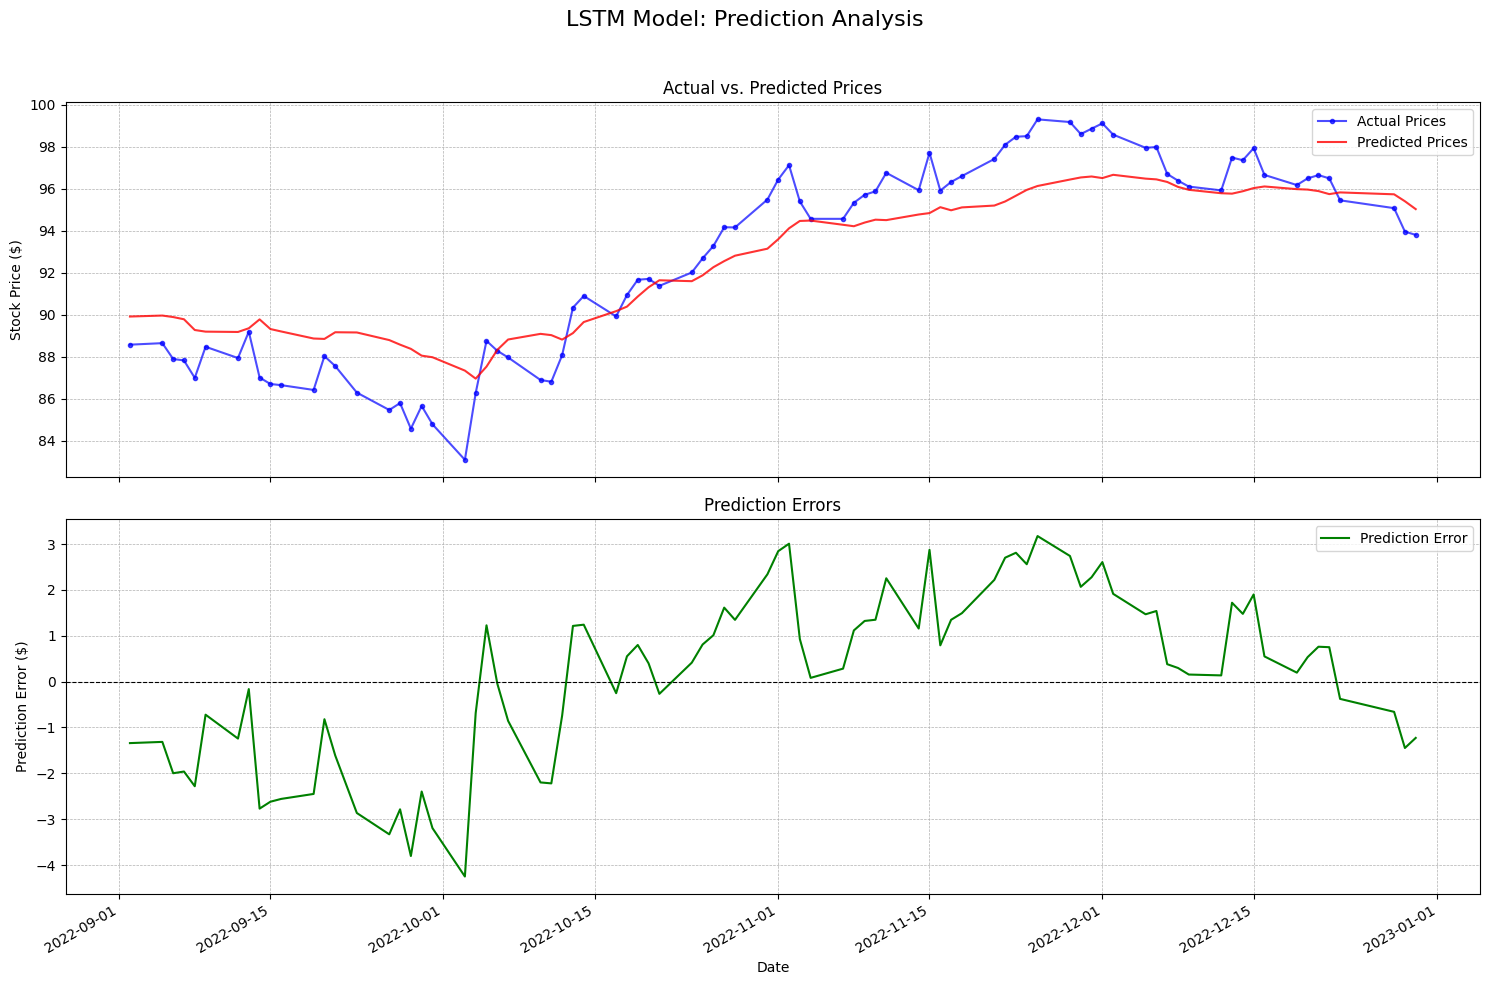


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
651 2022-10-06         88.29        88.330002  -0.04            0.04
672 2022-11-04         94.57        94.489998   0.08            0.08
698 2022-12-12         95.93        95.790001   0.14            0.14
697 2022-12-09         96.11        95.959999   0.15            0.15
635 2022-09-13         89.20        89.360001  -0.16            0.16

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10        87.339996  -4.25            4.25
645 2022-09-28         84.58        88.379997  -3.80            3.80
643 2022-09-26         85.47        88.800003  -3.33            3.33
647 2022-09-30         84.79        87.980003  -3.19            3.19
687 2022-11-25         99.31        96.139999   3.17            3.17

--- Statistical Summary of Error

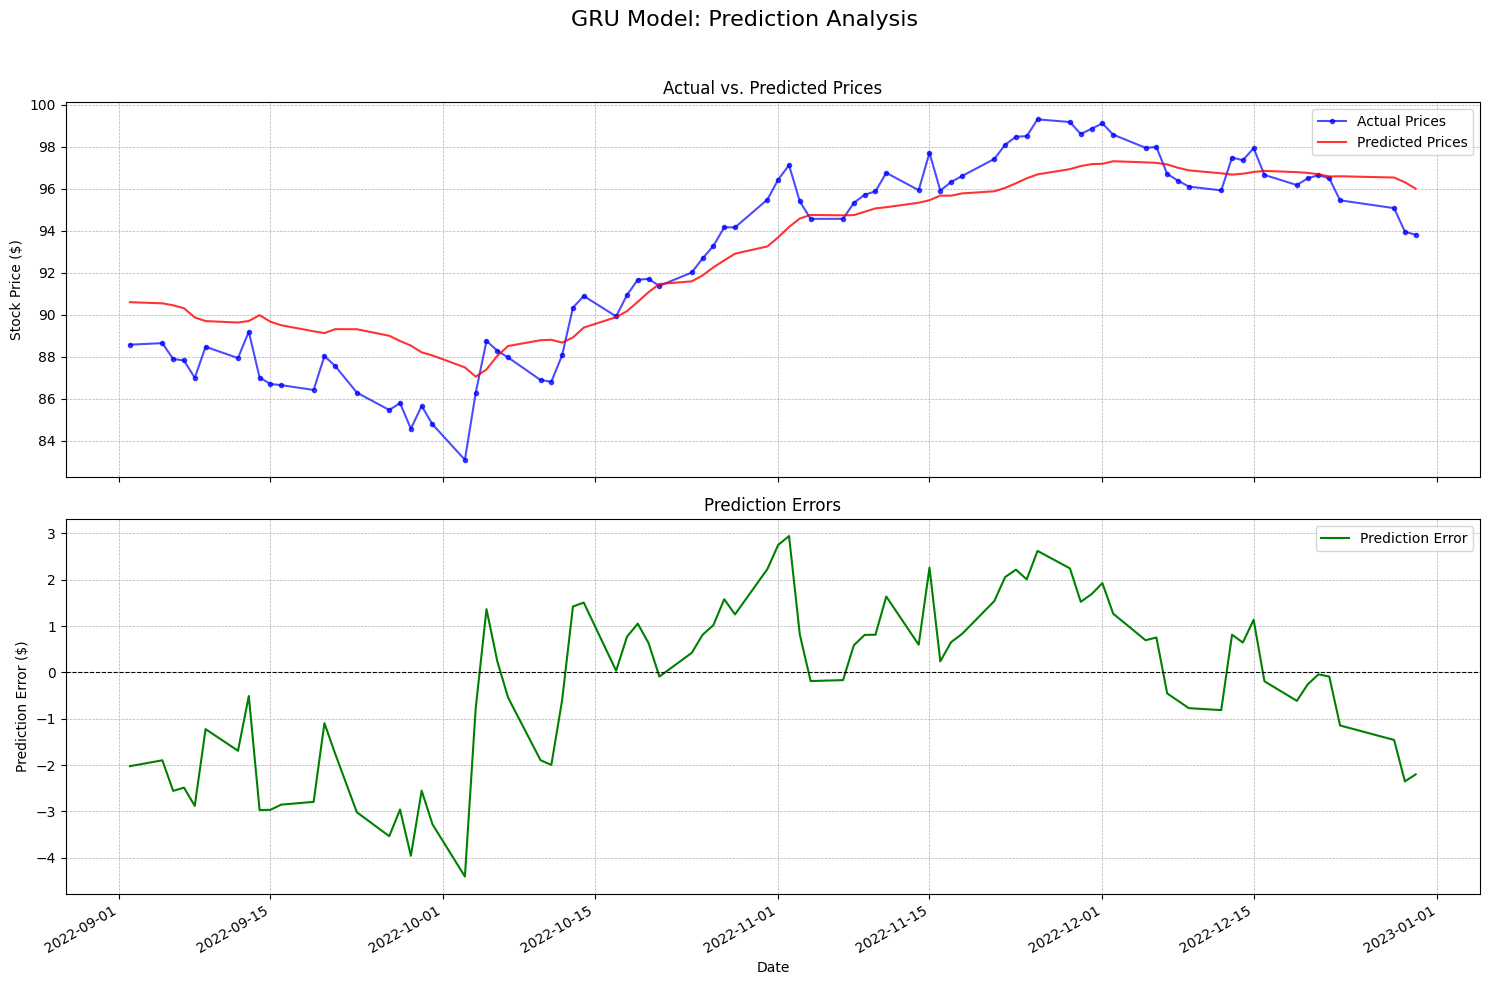


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
658 2022-10-17         89.93        89.889999   0.03            0.03
705 2022-12-21         96.66        96.699997  -0.04            0.04
706 2022-12-22         96.50        96.589996  -0.09            0.09
662 2022-10-21         91.38        91.470001  -0.09            0.09
673 2022-11-07         94.57        94.739998  -0.17            0.17

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10        87.500000  -4.40            4.40
645 2022-09-28         84.58        88.540001  -3.96            3.96
643 2022-09-26         85.47        89.000000  -3.53            3.53
647 2022-09-30         84.79        88.059998  -3.28            3.28
642 2022-09-23         86.30        89.309998  -3.02            3.02

--- Statistical Summary of Error

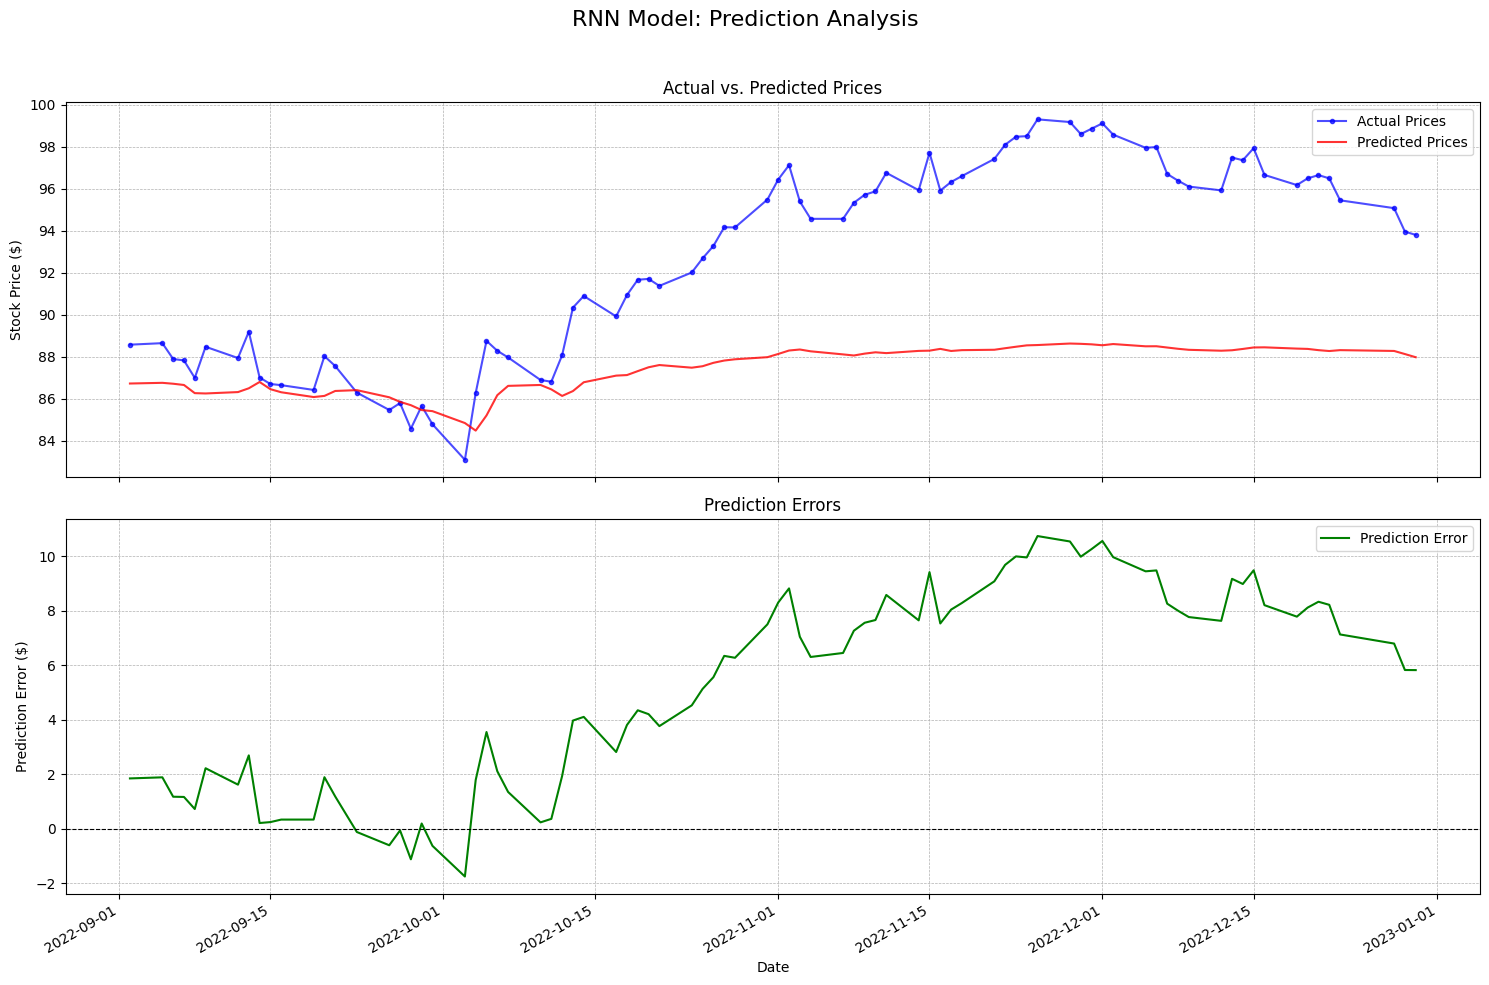


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
644 2022-09-27         85.80        85.860001  -0.06            0.06
642 2022-09-23         86.30        86.410004  -0.12            0.12
646 2022-09-29         85.66        85.470001   0.19            0.19
636 2022-09-14         87.02        86.800003   0.21            0.21
653 2022-10-10         86.90        86.660004   0.24            0.24

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
687 2022-11-25         99.31        88.559998  10.75           10.75
691 2022-12-01         99.12        88.550003  10.57           10.57
688 2022-11-28         99.18        88.629997  10.55           10.55
690 2022-11-30         98.87        88.599998  10.27           10.27
685 2022-11-23         98.48        88.480003  10.00           10.00

--- Statistical Summary of Error

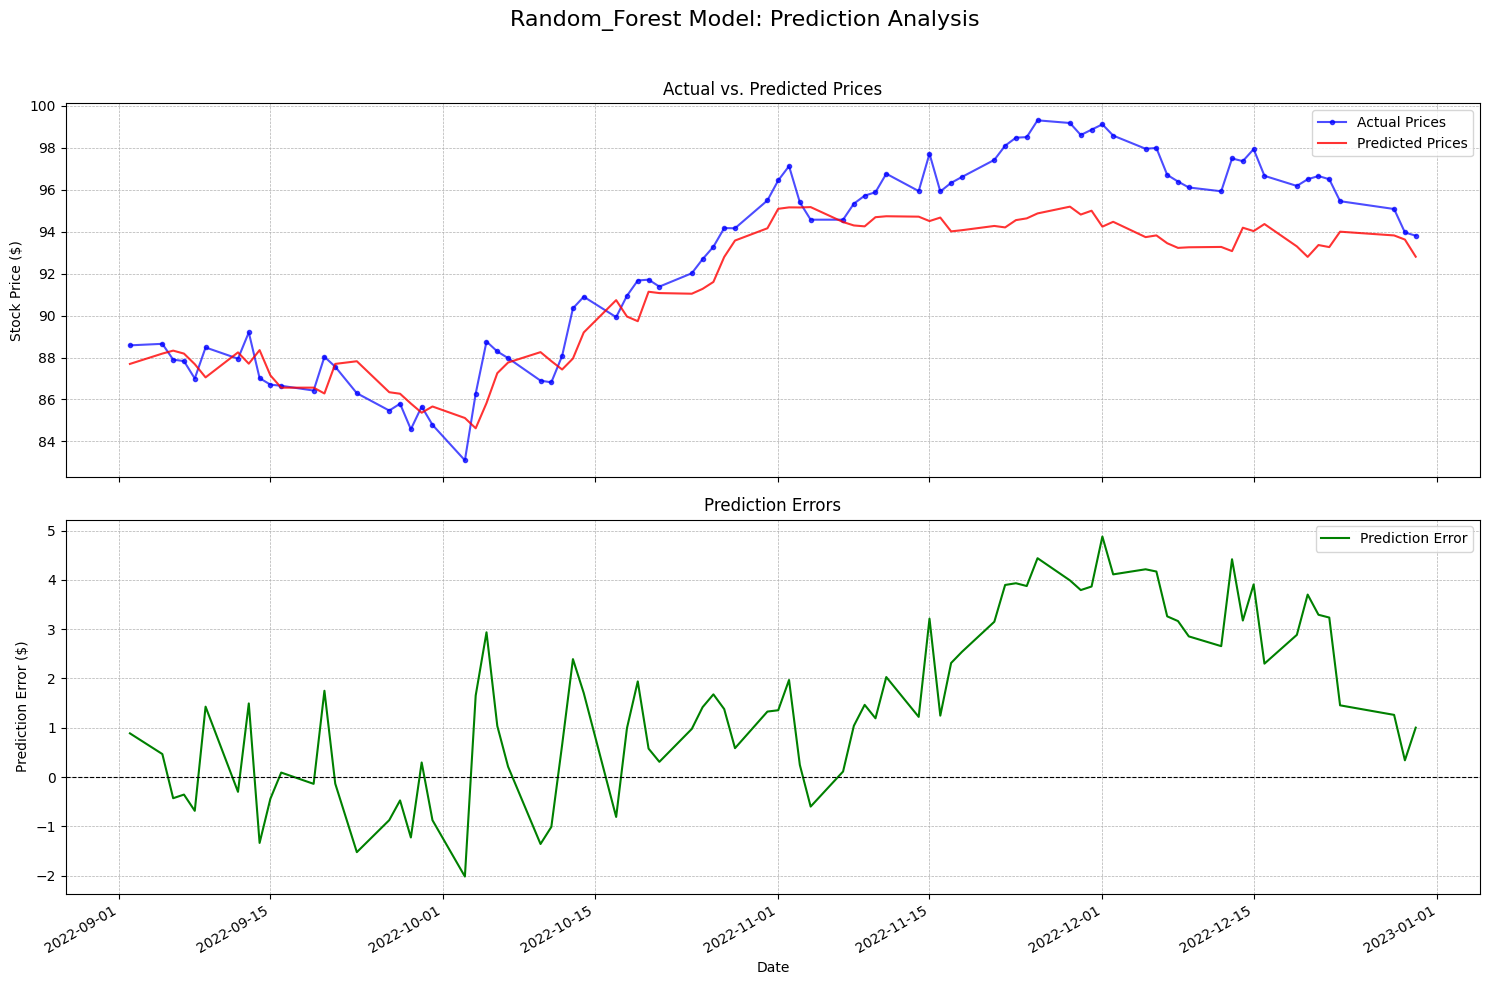


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
638 2022-09-16         86.65            86.56   0.09            0.09
673 2022-11-07         94.57            94.46   0.11            0.11
641 2022-09-21         87.56            87.70  -0.13            0.13
639 2022-09-19         86.42            86.56  -0.14            0.14
652 2022-10-07         87.97            87.76   0.21            0.21

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
691 2022-12-01         99.12            94.24   4.88            4.88
687 2022-11-25         99.31            94.87   4.44            4.44
699 2022-12-13         97.49            93.07   4.42            4.42
693 2022-12-05         97.96            93.74   4.21            4.21
694 2022-12-06         97.99            93.82   4.17            4.17

--- Statistical Summary of Error

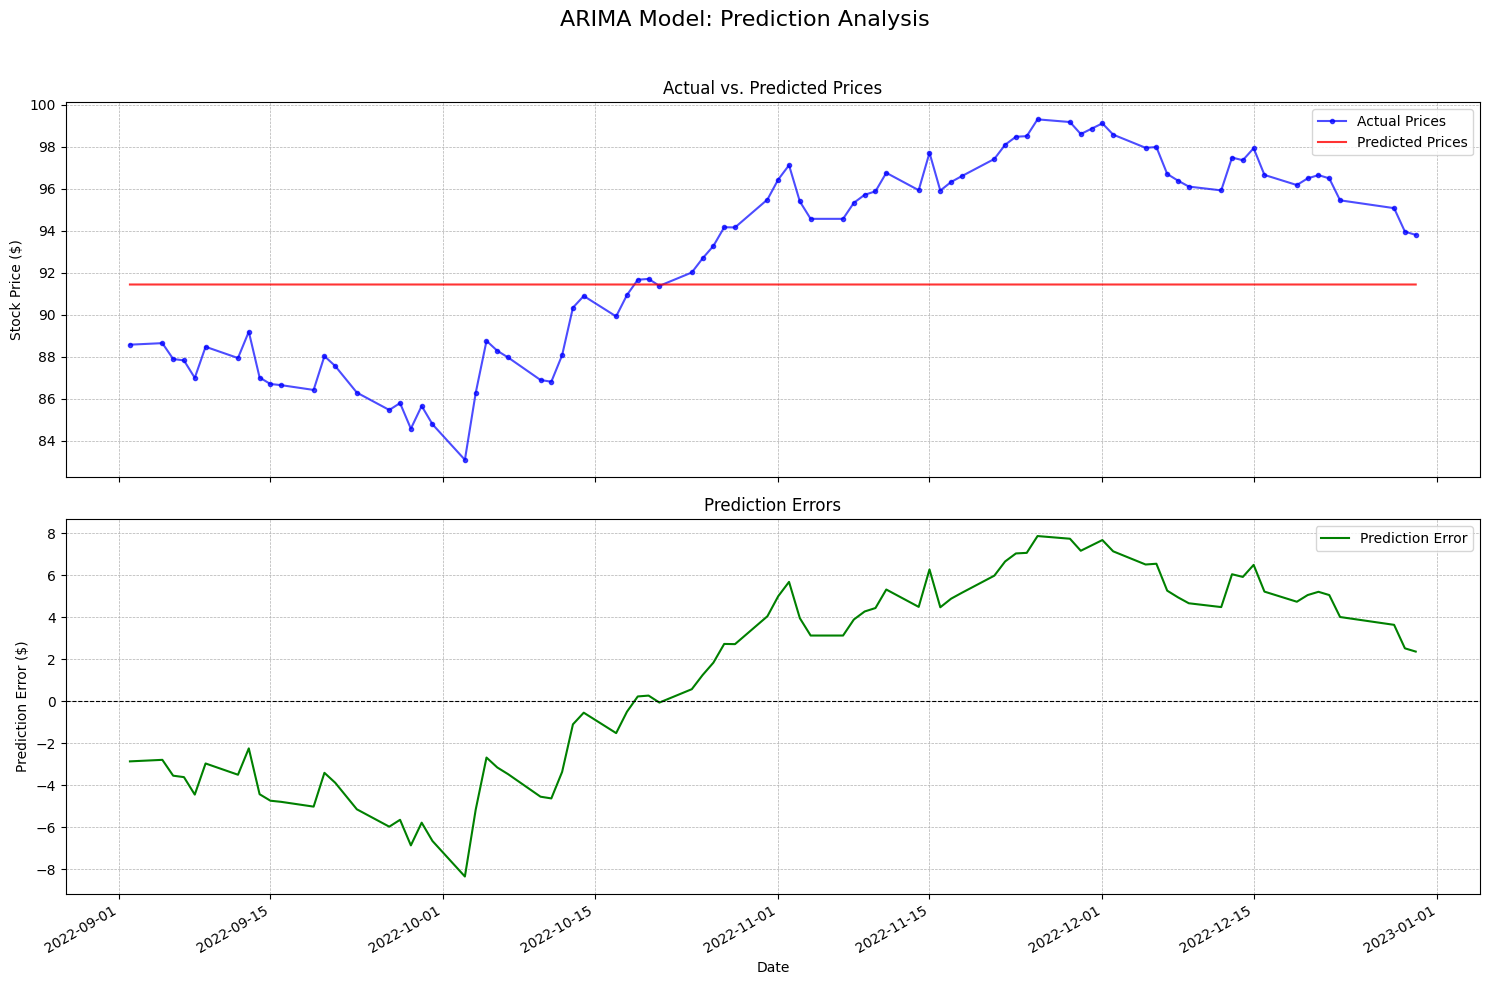


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
662 2022-10-21         91.38            91.45  -0.06            0.06
660 2022-10-19         91.67            91.45   0.23            0.23
661 2022-10-20         91.71            91.45   0.27            0.27
659 2022-10-18         90.94            91.45  -0.50            0.50
657 2022-10-14         90.90            91.45  -0.55            0.55

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10            91.45  -8.35            8.35
687 2022-11-25         99.31            91.45   7.87            7.87
688 2022-11-28         99.18            91.45   7.74            7.74
691 2022-12-01         99.12            91.45   7.67            7.67
690 2022-11-30         98.87            91.45   7.42            7.42

--- Statistical Summary of Error

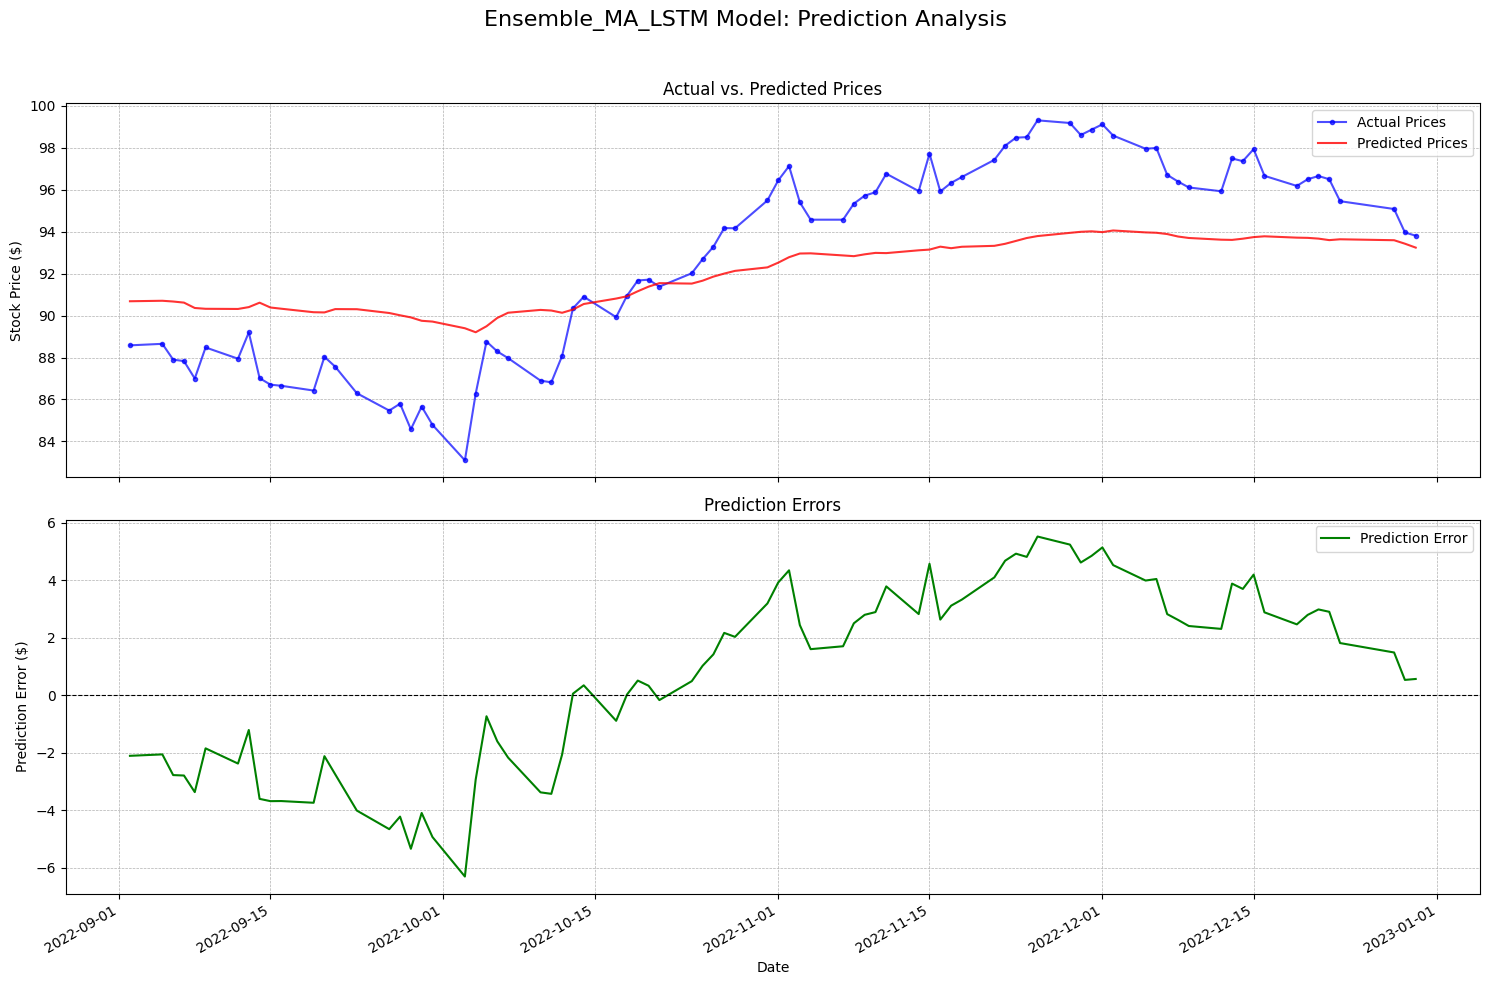


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
659 2022-10-18         90.94            90.92   0.03            0.03
656 2022-10-13         90.34            90.29   0.06            0.06
662 2022-10-21         91.38            91.55  -0.17            0.17
661 2022-10-20         91.71            91.38   0.33            0.33
657 2022-10-14         90.90            90.55   0.35            0.35

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10            89.40  -6.30            6.30
687 2022-11-25         99.31            93.79   5.52            5.52
645 2022-09-28         84.58            89.91  -5.33            5.33
688 2022-11-28         99.18            93.95   5.24            5.24
691 2022-12-01         99.12            93.98   5.14            5.14

--- Statistical Summary of Error

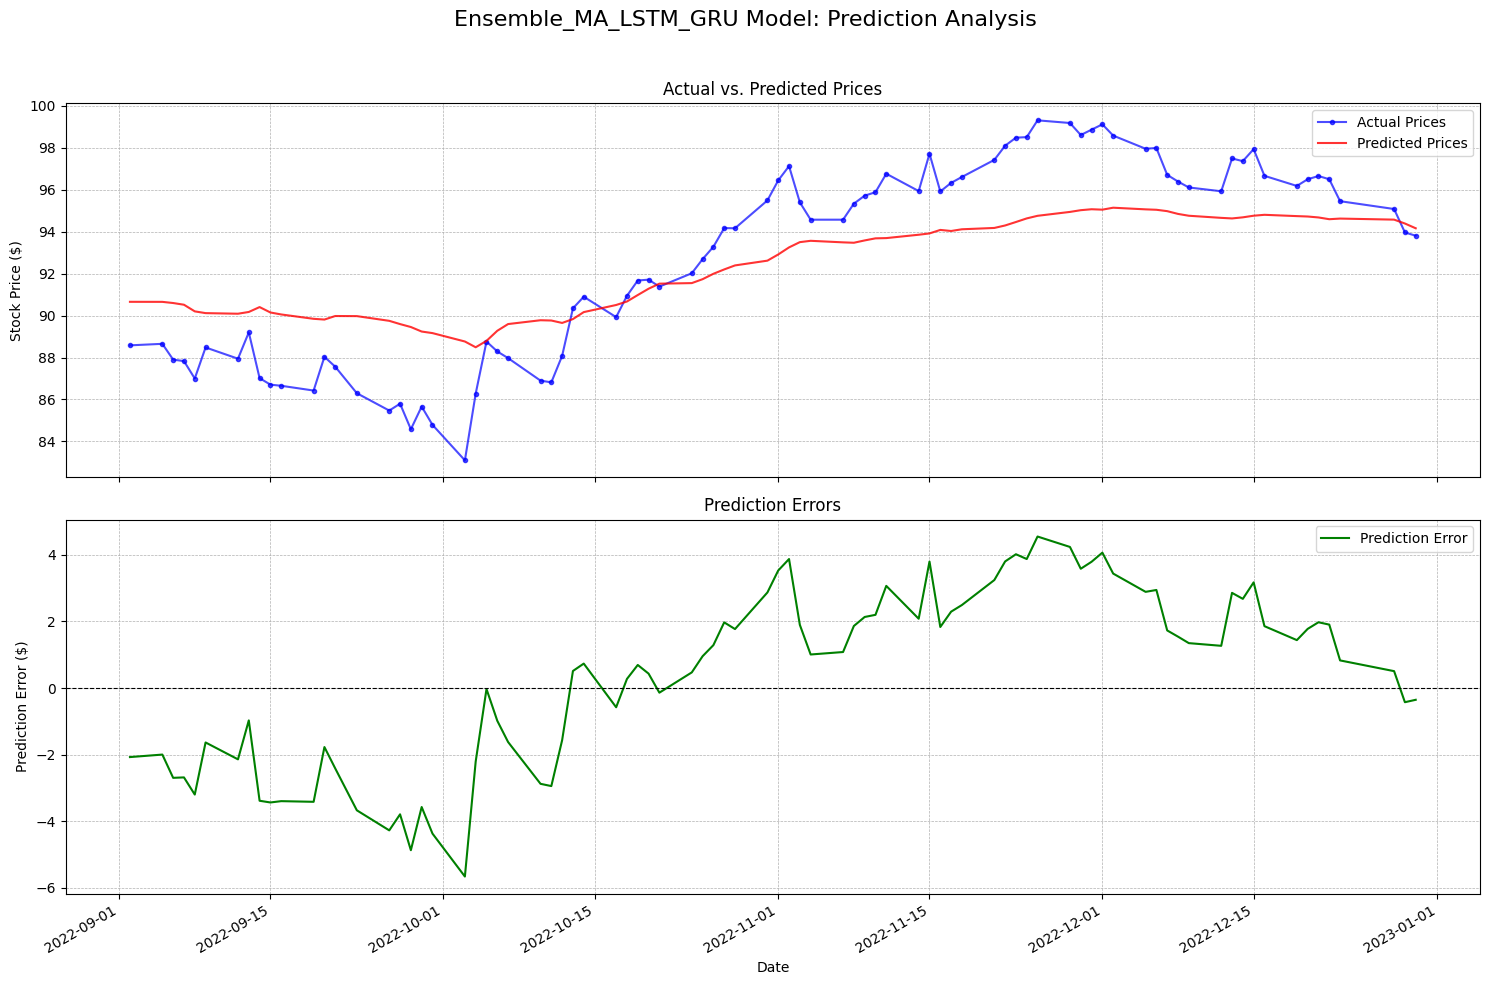


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
650 2022-10-05         88.76            88.79  -0.03            0.03
662 2022-10-21         91.38            91.52  -0.14            0.14
659 2022-10-18         90.94            90.67   0.27            0.27
710 2022-12-30         93.81            94.16  -0.35            0.35
709 2022-12-29         93.96            94.39  -0.43            0.43

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10            88.76  -5.67            5.67
645 2022-09-28         84.58            89.45  -4.88            4.88
687 2022-11-25         99.31            94.76   4.55            4.55
647 2022-09-30         84.79            89.16  -4.38            4.38
643 2022-09-26         85.47            89.75  -4.28            4.28

--- Statistical Summary of Error

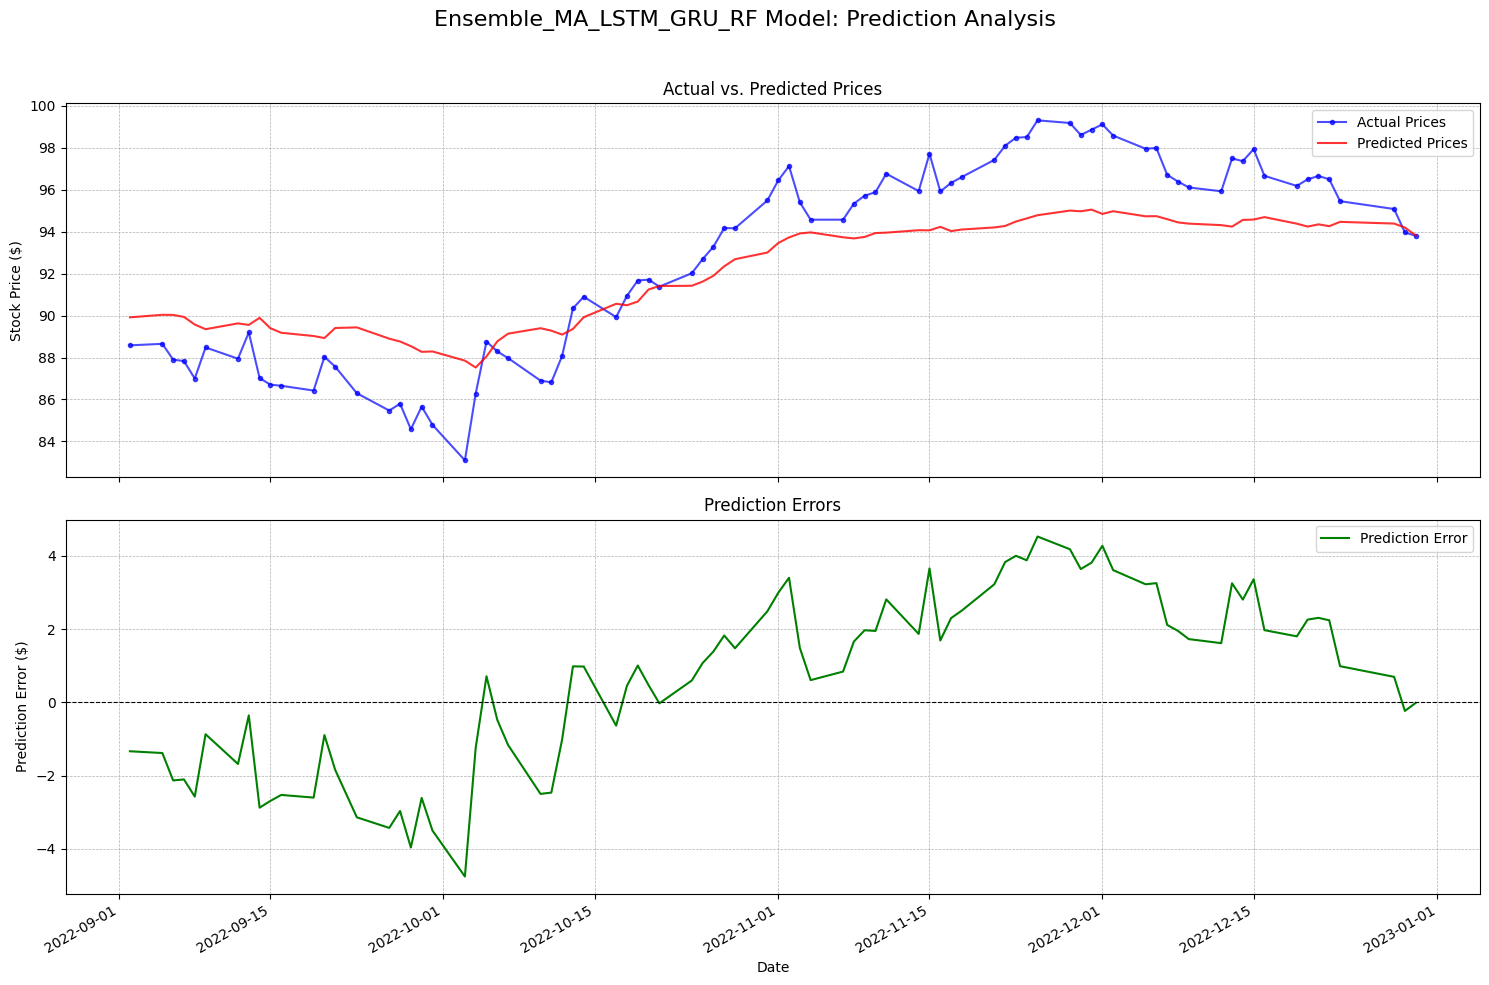


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
710 2022-12-30         93.81            93.82  -0.02            0.02
662 2022-10-21         91.38            91.41  -0.03            0.03
709 2022-12-29         93.96            94.20  -0.24            0.24
635 2022-09-13         89.20            89.56  -0.36            0.36
659 2022-10-18         90.94            90.49   0.45            0.45

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10            87.85  -4.76            4.76
687 2022-11-25         99.31            94.79   4.53            4.53
691 2022-12-01         99.12            94.85   4.27            4.27
688 2022-11-28         99.18            95.01   4.18            4.18
685 2022-11-23         98.48            94.48   4.00            4.00

--- Statistical Summary of Error

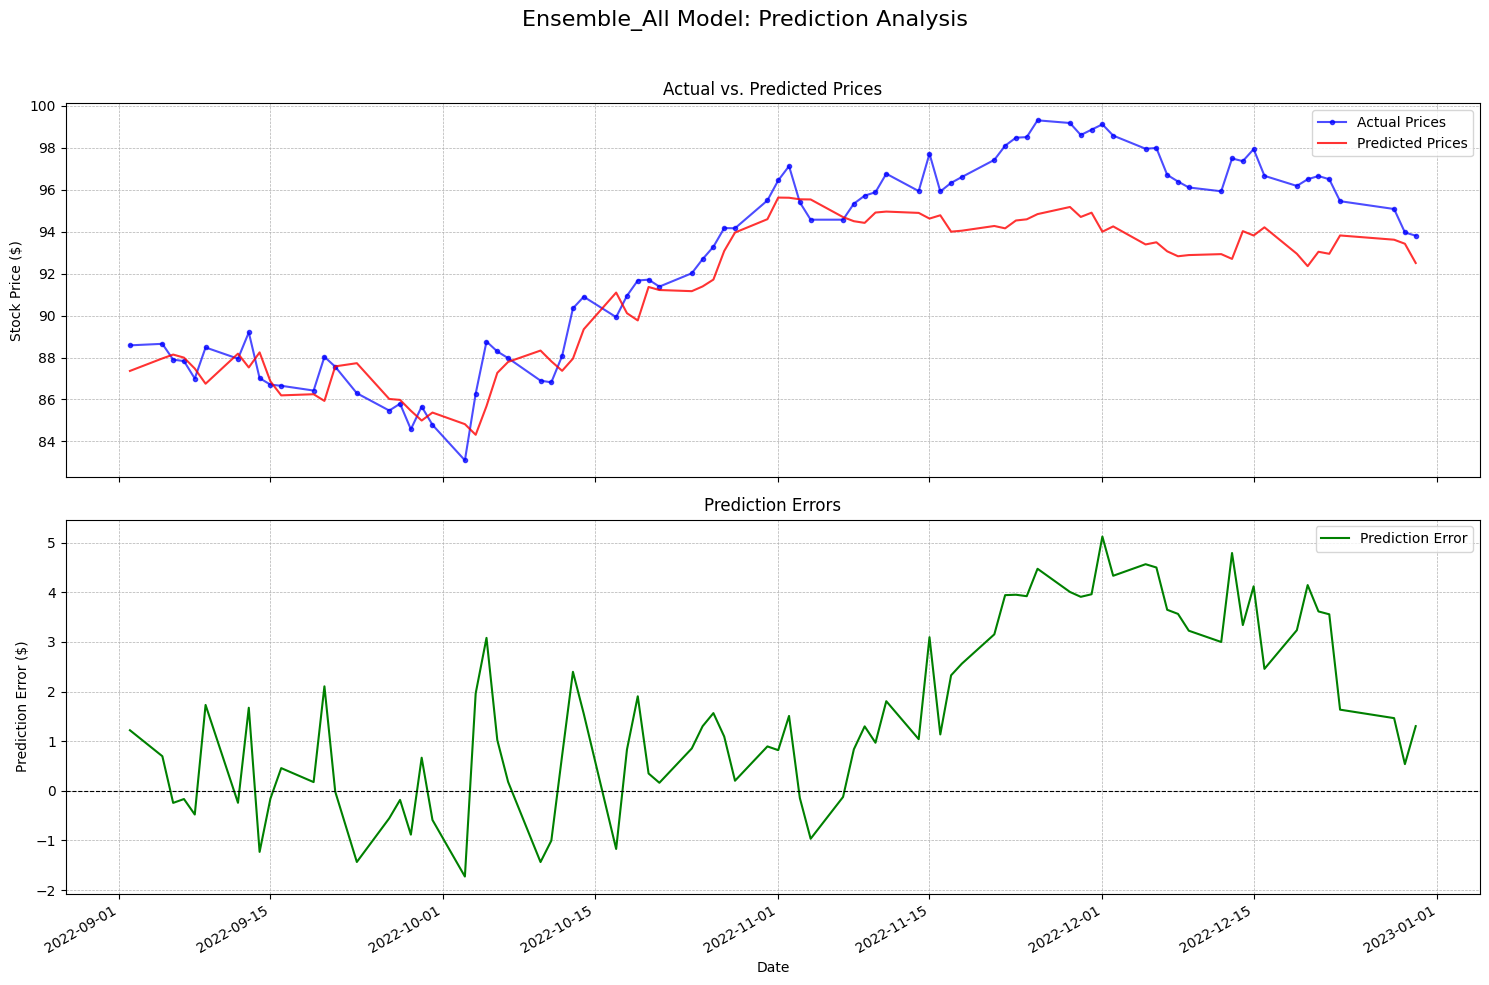


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
641 2022-09-21         87.56            87.58  -0.02            0.02
673 2022-11-07         94.57            94.70  -0.12            0.12
671 2022-11-03         95.40            95.54  -0.14            0.14
637 2022-09-15         86.71            86.86  -0.16            0.16
662 2022-10-21         91.38            91.22   0.16            0.16

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
691 2022-12-01         99.12            94.00   5.12            5.12
699 2022-12-13         97.49            92.70   4.79            4.79
693 2022-12-05         97.96            93.39   4.56            4.56
694 2022-12-06         97.99            93.49   4.50            4.50
687 2022-11-25         99.31            94.84   4.47            4.47

--- Statistical Summary of Error

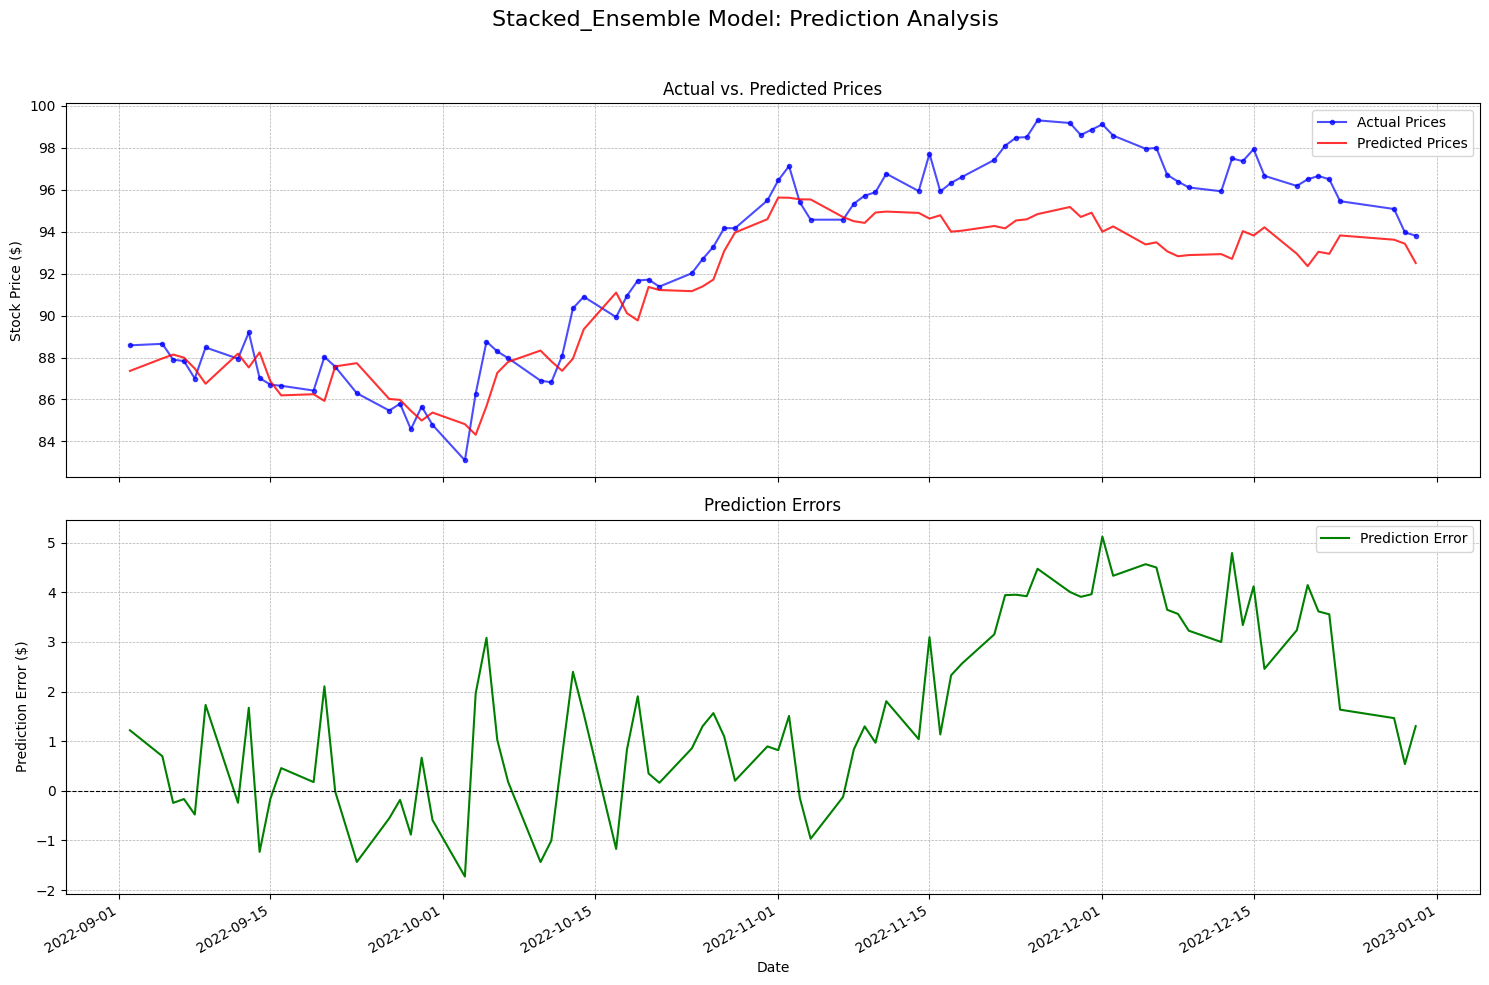


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
641 2022-09-21         87.56            87.58  -0.02            0.02
673 2022-11-07         94.57            94.70  -0.12            0.12
671 2022-11-03         95.40            95.54  -0.14            0.14
637 2022-09-15         86.71            86.86  -0.16            0.16
662 2022-10-21         91.38            91.22   0.16            0.16

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
691 2022-12-01         99.12            94.00   5.12            5.12
699 2022-12-13         97.49            92.70   4.79            4.79
693 2022-12-05         97.96            93.39   4.56            4.56
694 2022-12-06         97.99            93.49   4.50            4.50
687 2022-11-25         99.31            94.84   4.47            4.47

--- Statistical Summary of Error

In [28]:
# Model Evaluation and Visualization
# --- Prepare Data for Evaluation ---
# Extract the actual prices and dates from the dataframe
actual_prices = predictions_viz_data['Actual']
prediction_dates = predictions_viz_data['Date']

# Get a list of all model prediction columns to iterate over
model_columns = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]

# --- Calculate and Display Overall Metrics ---
metrics = []
for model_name in model_columns:
    pred_prices = predictions_viz_data[model_name]
    mae = mean_absolute_error(actual_prices, pred_prices)
    mse = mean_squared_error(actual_prices, pred_prices)
    rmse = np.sqrt(mse)
    metrics.append({'Model': model_name, 'MAE ($)': mae, 'MSE': mse, 'RMSE ($)': rmse})

metrics_df = pd.DataFrame(metrics).set_index('Model')
print("\n--- Overall Prediction Performance Metrics (Sorted by MAE) ---")
print(metrics_df.sort_values('MAE ($)').round(4))
print("==============================================================")


# --- Detailed Analysis and Visualization for Each Model ---
for model_name in model_columns:
    print(f"\n--- Detailed Analysis for {model_name} Model ---")
    
    # Create a results DataFrame for the current model
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual_Price': actual_prices.values,
        'Predicted_Price': predictions_viz_data[model_name].values
    })
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    # Save this model's predictions to a CSV file
    predictions_filename = os.path.join(DATA_DIR, f"{COMPANY}_predictions_{model_name}.csv")
    results_df.to_csv(predictions_filename, index=False)
    print(f"✅ Predictions for {model_name} saved to: {predictions_filename}")
    
    # Plot predictions vs. actuals and the prediction errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f'{model_name} Model: Prediction Analysis', fontsize=16)
    
    ax1.plot(results_df['Date'], results_df['Actual_Price'], label='Actual Prices', color='blue', linestyle='-', marker='.', alpha=0.7)
    ax1.plot(results_df['Date'], results_df['Predicted_Price'], label='Predicted Prices', color='red', linestyle='-', alpha=0.8)
    ax1.set_ylabel('Stock Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, linestyle='--', linewidth=0.5)
    
    ax2.plot(results_df['Date'], results_df['Error'], label='Prediction Error', color='green', linestyle='-')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Prediction Error ($)')
    ax2.set_title('Prediction Errors')
    ax2.legend()
    ax2.grid(True, linestyle='--', linewidth=0.5)
    
    # Improve date formatting on the x-axis
    fig.autofmt_xdate()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Show the best and worst predictions for this model
    print("\n--- Prediction Highlights & Lowlights ---")
    print("\n✅ 5 Best Predictions (Lowest Absolute Error):")
    print(results_df.sort_values('Absolute_Error').head(5).round(2))
    print("\n❌ 5 Worst Predictions (Highest Absolute Error):")
    print(results_df.sort_values('Absolute_Error', ascending=False).head(5).round(2))
    
    print("\n--- Statistical Summary of Errors ---")
    print(results_df['Error'].describe().round(4))

✅ Found 'predictions_viz_data' DataFrame. Ready for visualization.

--- Interactive Candlestick Visualization ---
1: LSTM
2: GRU
3: RNN
4: Random_Forest
5: ARIMA
6: Ensemble_MA_LSTM
7: Ensemble_MA_LSTM_GRU
8: Ensemble_MA_LSTM_GRU_RF
9: Ensemble_All
10: Stacked_Ensemble
q: Quit


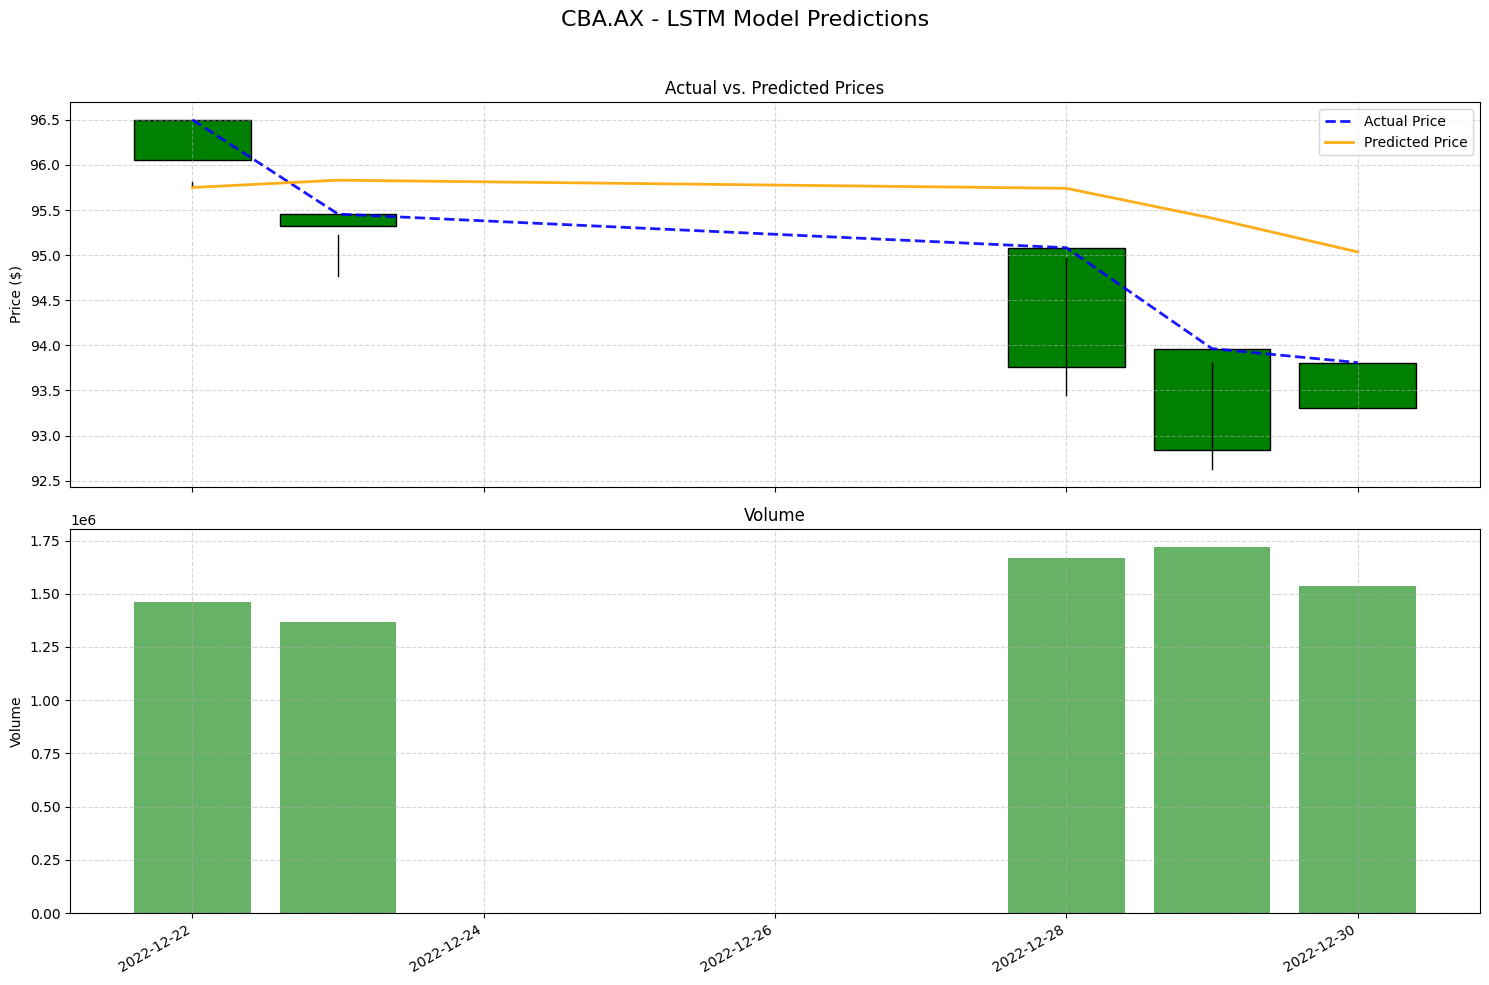


--- Interactive Candlestick Visualization ---
1: LSTM
2: GRU
3: RNN
4: Random_Forest
5: ARIMA
6: Ensemble_MA_LSTM
7: Ensemble_MA_LSTM_GRU
8: Ensemble_MA_LSTM_GRU_RF
9: Ensemble_All
10: Stacked_Ensemble
q: Quit


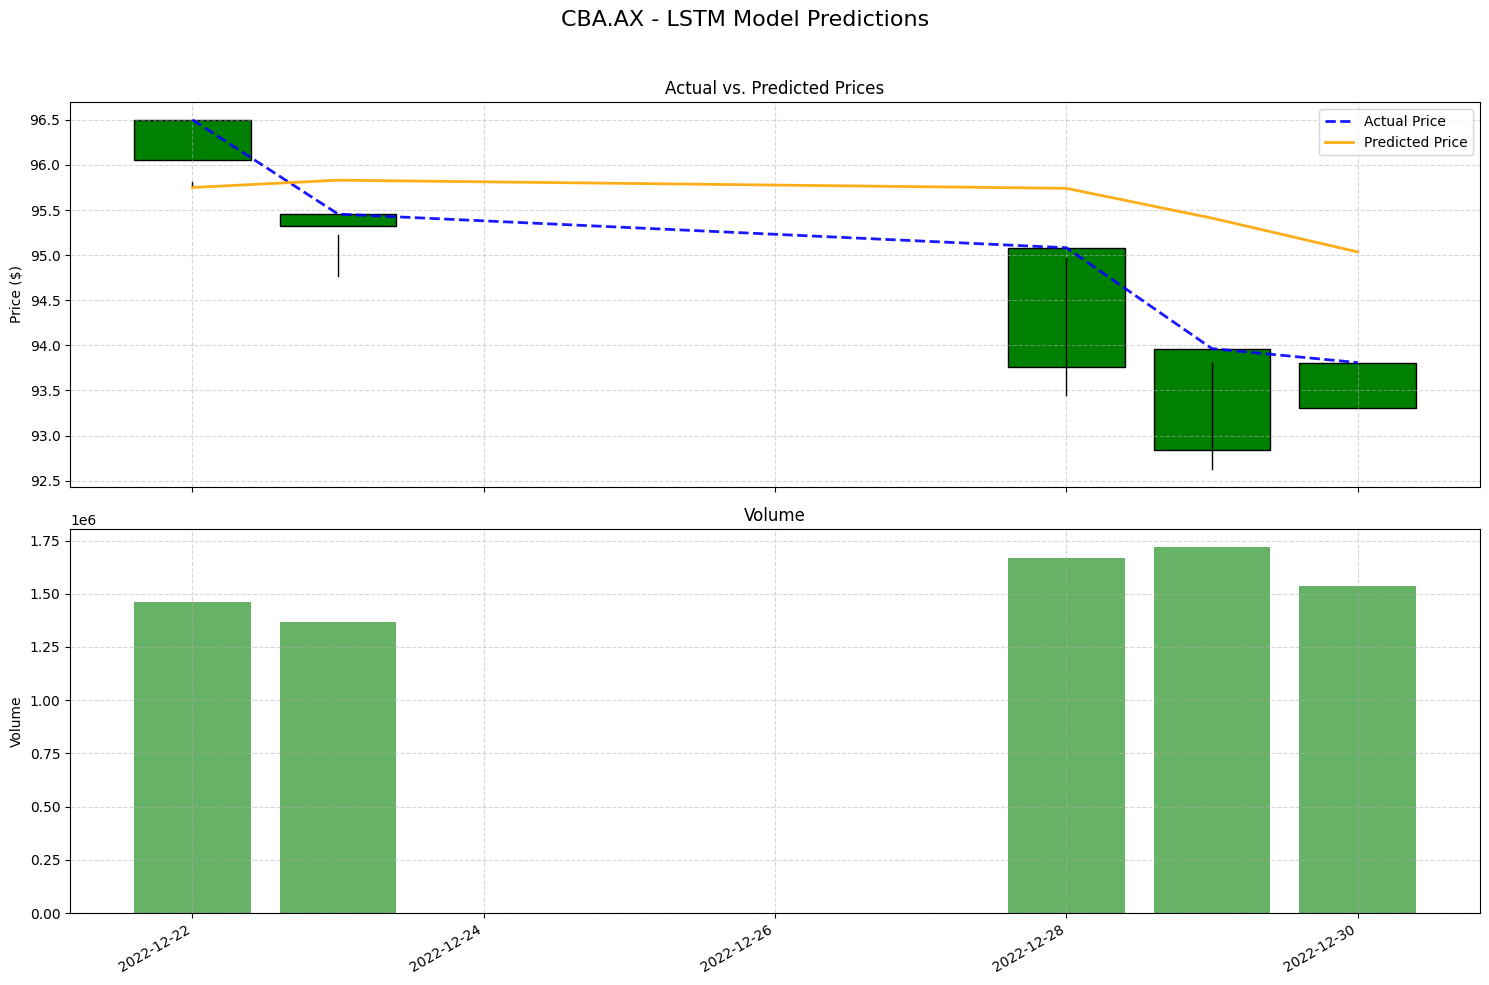


--- Interactive Candlestick Visualization ---
1: LSTM
2: GRU
3: RNN
4: Random_Forest
5: ARIMA
6: Ensemble_MA_LSTM
7: Ensemble_MA_LSTM_GRU
8: Ensemble_MA_LSTM_GRU_RF
9: Ensemble_All
10: Stacked_Ensemble
q: Quit
Exiting visualization.


In [30]:
# Interactive Candlestick Visualization

# --- Prerequisite Check ---
try:
    predictions_viz_data
    print("✅ Found 'predictions_viz_data' DataFrame. Ready for visualization.")
except NameError:
    print("❌ CRITICAL ERROR: 'predictions_viz_data' DataFrame not found.")
    print("   Please ensure the 'Ensemble Modeling' and 'Improved Stacked Ensemble Modeling' cells have been run successfully.")
    raise

# --- Visualization Functions (no changes needed) ---
def create_candlestick_data(df, n_days=1):
    """Aggregate daily data into N-day candlesticks."""
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    if n_days == 1:
        return df
    grouped = df.groupby(np.arange(len(df)) // n_days).agg(
        Date=('Date', 'first'),
        Open=('Open', 'first'),
        High=('High', 'max'),
        Low=('Low', 'min'),
        Close=('Close', 'last'),
        Volume=('Volume', 'sum'),
        Actual_Price=('Actual_Price', 'last'),
        Predicted_Price=('Predicted_Price', 'last'),
    )
    return grouped

def plot_prediction_candlesticks(df, title, n_days, limit_days):
    """Create a candlestick chart with predictions overlay."""
    plot_data = df.copy()
    if limit_days:
        plot_data = plot_data.tail(limit_days)
    plot_data = create_candlestick_data(plot_data, n_days=n_days)
    
    if plot_data.empty:
        print("No data available to plot.")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(title, fontsize=16)
    plot_data['Date_Num'] = mdates.date2num(pd.to_datetime(plot_data['Date']))
    width = 0.8 * n_days
    
    for index, row in plot_data.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        ax1.plot([row['Date_Num'], row['Date_Num']], [row['Low'], row['High']], color='black', linewidth=1)
        body = Rectangle((row['Date_Num'] - width/2, min(row['Open'], row['Close'])), width, abs(row['Close'] - row['Open']), facecolor=color, edgecolor='black')
        ax1.add_patch(body)
    
    ax1.plot(plot_data['Date_Num'], plot_data['Actual_Price'], label='Actual Price', color='blue', linestyle='--', alpha=0.9, linewidth=2)
    ax1.plot(plot_data['Date_Num'], plot_data['Predicted_Price'], label='Predicted Price', color='orange', linestyle='-', alpha=0.9, linewidth=2)
    ax1.set_ylabel('Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    volume_colors = ['green' if row['Close'] >= row['Open'] else 'red' for _, row in plot_data.iterrows()]
    ax2.bar(plot_data['Date_Num'], plot_data['Volume'], width=width, color=volume_colors, alpha=0.6)
    ax2.set_ylabel('Volume')
    ax2.set_title('Volume')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Interactive Loop ---
# Get the list of all available models for visualization
available_models = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]
model_map = {str(i + 1): model for i, model in enumerate(available_models)}

while True:
    print("\n--- Interactive Candlestick Visualization ---")
    # Dynamically create the menu of all available models
    for key, model_name in model_map.items():
        print(f"{key}: {model_name}")
    print("q: Quit")
    
    choice = input(f"Enter your choice (1-{len(model_map)}/q): ").strip().lower()
    
    if choice == 'q':
        print("Exiting visualization.")
        break
    
    if choice not in model_map:
        print("❌ Invalid choice. Please select a number from the list.")
        continue
    
    model_name = model_map[choice]
    
    try:
        n_days_input = input("Enter number of days per candlestick (default: 1): ").strip()
        n_days = int(n_days_input) if n_days_input else 1
        
        limit_days_input = input("Enter number of recent days to display (default: 90): ").strip()
        limit_days = int(limit_days_input) if limit_days_input else 90
    except ValueError:
        print("❌ Invalid number. Using defaults.")
        n_days, limit_days = 1, 90
    
    try:
        # --- Prepare DataFrame for Plotting ---
        # Merge OHLCV data from `test_data` with predictions from `predictions_viz_data`.
        
        pred_subset = predictions_viz_data[['Date', 'Actual', model_name]].copy()
        
        # The original data uses 'Price' for the open price. Rename it to 'Open' for the plot.
        if 'Open' not in test_data.columns and 'Price' in test_data.columns:
             test_data_plot = test_data.rename(columns={'Price': 'Open'})
        else:
             test_data_plot = test_data.copy()

        # Merge on 'Date' to ensure data is perfectly aligned
        plot_df = pd.merge(test_data_plot, pred_subset, on='Date', how='inner')
        
        # Rename columns to what the plotting function expects
        plot_df = plot_df.rename(columns={'Actual': 'Actual_Price', model_name: 'Predicted_Price'})
        
        # Call the plotting function
        plot_prediction_candlesticks(
            plot_df, 
            f"{COMPANY} - {model_name} Model Predictions", 
            n_days, 
            limit_days
        )
    except Exception as e:
        print(f"❌ An unexpected error occurred while preparing the plot:")


--- Boxplot Analysis Menu ---
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select period for historical analysis:
1: Monthly
2: Quarterly
3: Yearly
4: Weekly


2025-06-27 23:53:26,816 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 23:53:26,816 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 23:53:26,853 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 23:53:26,864 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 23:53:26,894 - INFO - Using categorical units to plot a list of strings that are all parsable as 

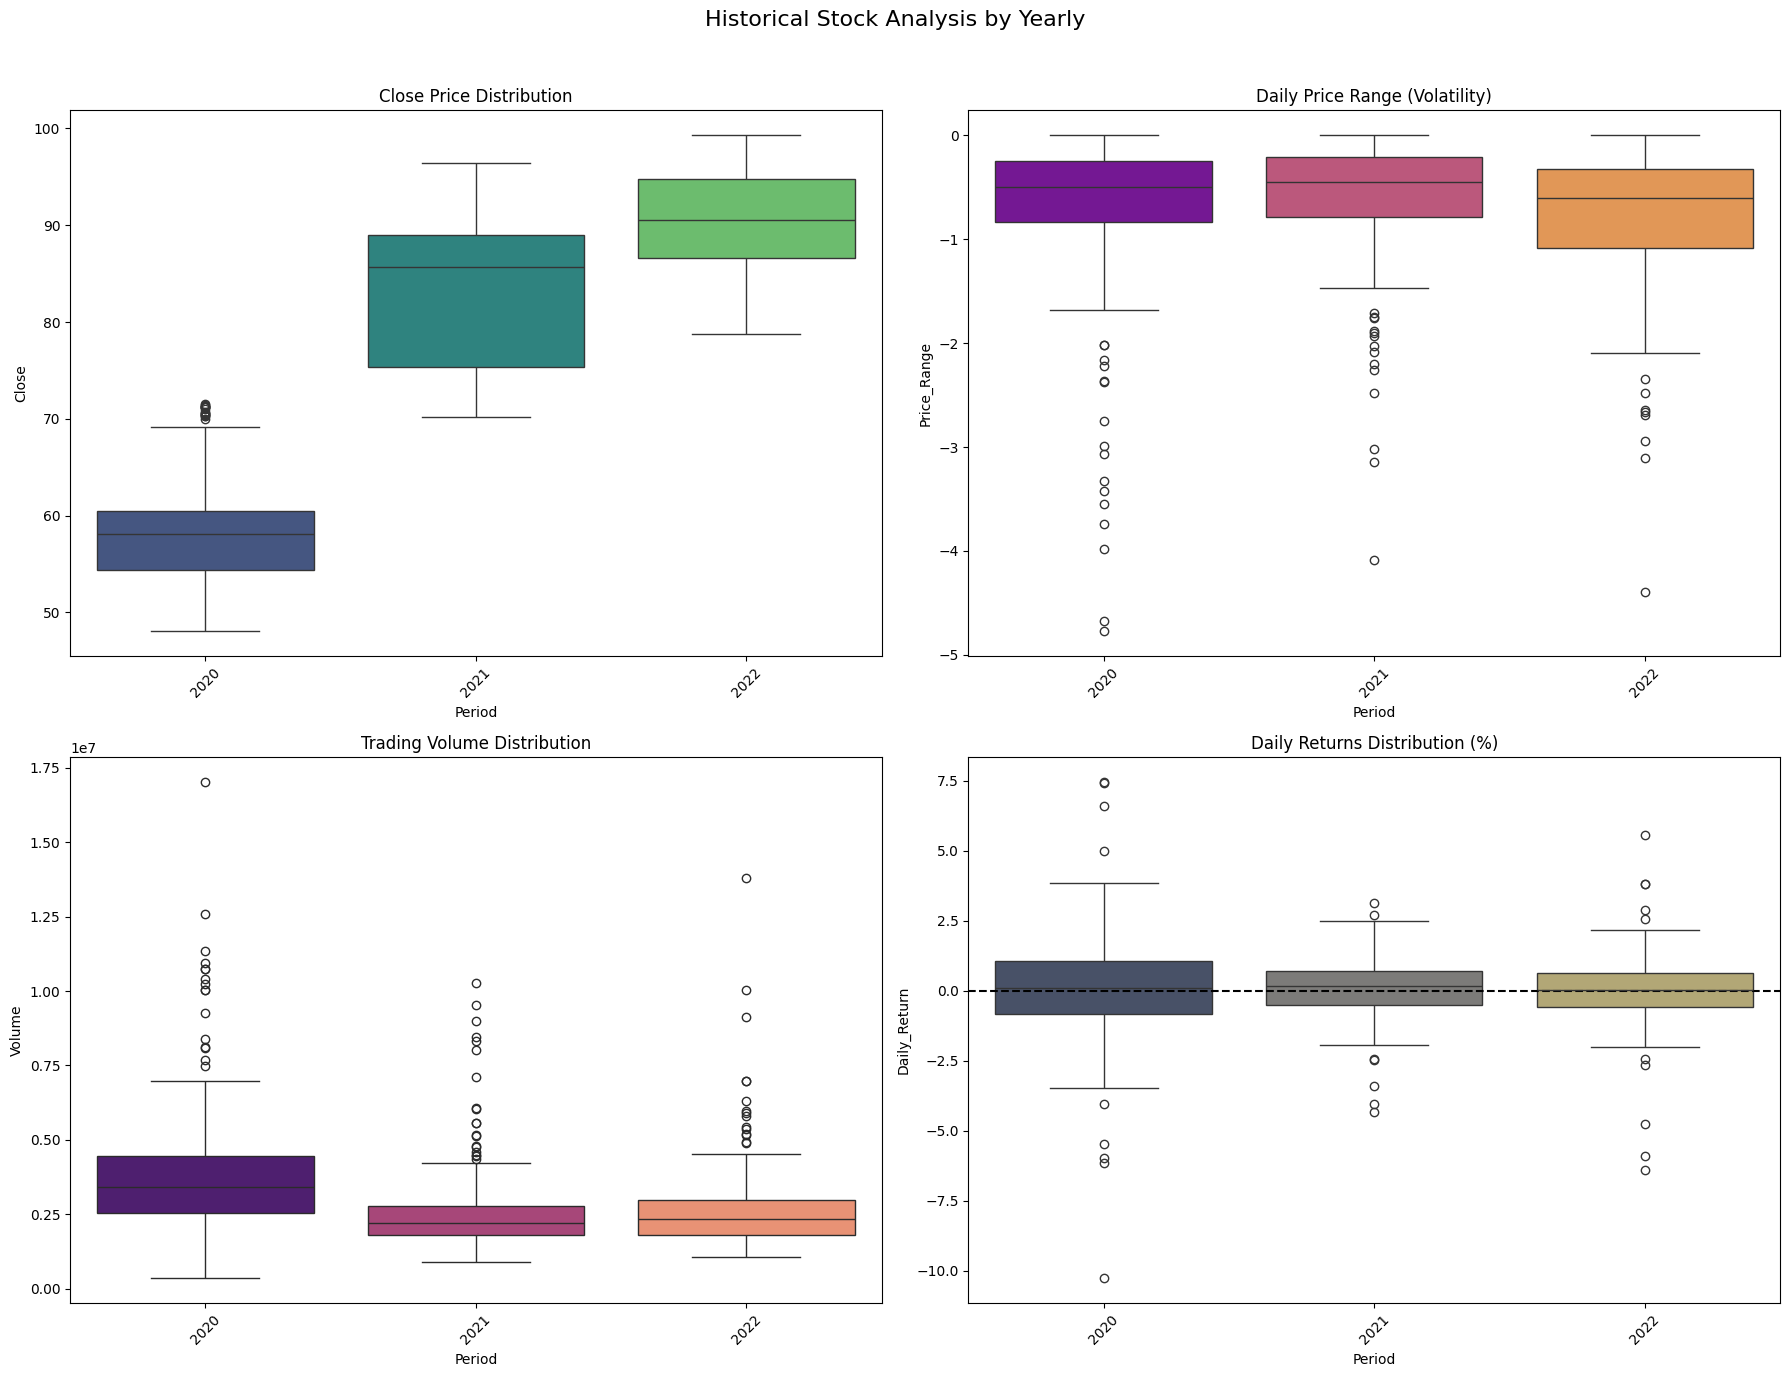


--- Boxplot Analysis Menu ---
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a model for prediction error analysis:
1: LSTM
2: GRU
3: RNN
4: Random_Forest
5: ARIMA
6: Ensemble_MA_LSTM
7: Ensemble_MA_LSTM_GRU
8: Ensemble_MA_LSTM_GRU_RF
9: Ensemble_All
10: Stacked_Ensemble


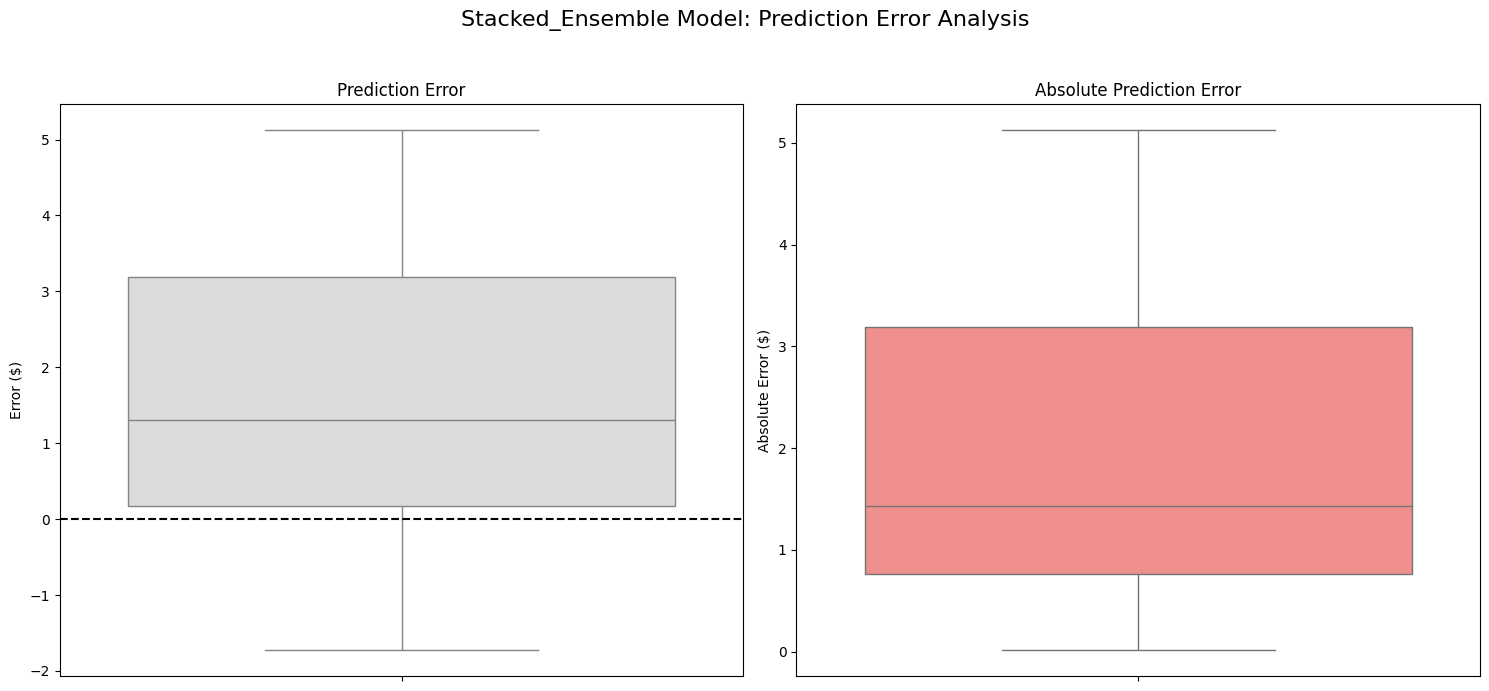


--- Boxplot Analysis Menu ---
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit
Exiting boxplot analysis.


In [31]:
# Boxplot Analysis
# --- Visualization Functions (no changes needed) ---
def create_boxplot_data(df, period='monthly'):
    """Prepare data for boxplot visualization."""
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    
    if period == 'monthly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-%m')
    elif period == 'quarterly':
        df_copy['Period'] = df_copy['Date'].dt.to_period('Q').astype(str)
    elif period == 'yearly':
        df_copy['Period'] = df_copy['Date'].dt.year.astype(str)
    elif period == 'weekly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-W%U')
    else:
        raise ValueError("Period must be one of 'monthly', 'quarterly', 'yearly', or 'weekly'")
    
    df_copy['Price_Range'] = df_copy['High'] - df_copy['Low']
    df_copy['Daily_Return'] = df_copy['Close'].pct_change() * 100
    return df_copy

def plot_price_boxplots(df, period='monthly'):
    """Create boxplots for historical stock data."""
    boxplot_data = create_boxplot_data(df, period)
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'Historical Stock Analysis by {period.title()}', fontsize=16)
    
    sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
    axes[0, 0].set_title('Close Price Distribution')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
    axes[0, 1].set_title('Daily Price Range (Volatility)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y='Volume', palette='magma')
    axes[1, 0].set_title('Trading Volume Distribution')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[1, 1], data=boxplot_data, x='Period', y='Daily_Return', palette='cividis')
    axes[1, 1].set_title('Daily Returns Distribution (%)')
    axes[1, 1].axhline(0, color='black', linestyle='--')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_prediction_error_boxplots(results_df, model_name):
    """Create boxplots for prediction errors."""
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f'{model_name} Model: Prediction Error Analysis', fontsize=16)
    
    sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
    ax1.axhline(0, color='black', linestyle='--')
    ax1.set_title('Prediction Error')
    ax1.set_ylabel('Error ($)')
    
    sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')
    ax2.set_title('Absolute Prediction Error')
    ax2.set_ylabel('Absolute Error ($)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Interactive Loop ---
while True:
    print("\n--- Boxplot Analysis Menu ---")
    print("1: Historical Data Analysis")
    print("2: Prediction Error Analysis")
    print("q: Quit")
    choice = input("Enter your choice (1/2/q): ").strip().lower()
    
    if choice == 'q':
        print("Exiting boxplot analysis.")
        break
    
    try:
        if choice == '1':
            print("\nSelect period for historical analysis:")
            print("1: Monthly\n2: Quarterly\n3: Yearly\n4: Weekly")
            period_choice = input("Enter choice [default: 1]: ").strip()
            period_map = {'1': 'monthly', '2': 'quarterly', '3': 'yearly', '4': 'weekly'}
            period = period_map.get(period_choice, 'monthly')
            
            # Concatenate train and test data to get the full historical range
            full_historical_df = pd.concat([train_data, test_data], ignore_index=True)
            plot_price_boxplots(full_historical_df, period=period)
        
        elif choice == '2':
            # Dynamically get all available models for error analysis
            available_models = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]
            model_map = {str(i + 1): model for i, model in enumerate(available_models)}
            
            print("\nSelect a model for prediction error analysis:")
            for key, model_name in model_map.items():
                print(f"{key}: {model_name}")
            
            model_choice = input(f"Enter choice (1-{len(model_map)}): ").strip()
            
            if model_choice not in model_map:
                print("❌ Invalid model choice.")
                continue
                
            model_name = model_map[model_choice]
            
            # Create the dataframe for the selected model from the master visualization data
            prediction_df = predictions_viz_data[['Actual', model_name]].copy()
            prediction_df.rename(columns={'Actual': 'Actual_Price', model_name: 'Predicted_Price'}, inplace=True)
            
            plot_prediction_error_boxplots(prediction_df, model_name)
        
        else:
            print("❌ Invalid choice. Please enter 1, 2, or q.")
            
    except Exception as e:
        print(f"❌ An error occurred: {e}")

In [33]:
# Multistep Prediction Functions
def solve_multivariate_multistep_prediction(model, last_sequence, k, scalers, feature_order):
    """Predict k days into the future using multivariate input."""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(k):
        next_close_scaled = model.predict(current_sequence.reshape(1, PREDICTION_DAYS, -1), verbose=0)[0, 0]
        predictions.append(scalers['Close'].inverse_transform([[next_close_scaled]])[0, 0])
        
        new_step = current_sequence[0, -1, :].copy()
        close_feature_index = feature_order.index('Close')
        new_step[close_feature_index] = next_close_scaled
        new_step = new_step.reshape(1, 1, current_sequence.shape[2])
        current_sequence = np.append(current_sequence[:, 1:, :], new_step, axis=1)
    
    return predictions

In [35]:
# Advanced Future Predictions
# --- Prerequisite Checks ---
try:
    # Check for all necessary models and variables
    all_models_performance
    lstm_model
    gru_model
    rnn_model
    rf_model
    fitted_arima
    meta_learner
    weights
    scalers
    test_values
    feature_columns
    PREDICTION_DAYS
    create_rf_features
    print("✅ All prerequisite models and variables found. Ready for future prediction.")
except NameError as e:
    print(f"❌ CRITICAL ERROR: A required variable or model is missing: {e}")
    print("   Please ensure all preceding cells, especially model training and ensemble creation, have been run successfully.")
    raise

# --- Unified Future Prediction Function ---
def generate_future_predictions(model_name, future_days, last_sequence, all_models, scalers, feature_columns):
    """
    Generates future predictions for a specified model.
    Handles individual, ensemble, and stacked models recursively.
    """
    # Unpack all models from the dictionary
    lstm_m = all_models.get('LSTM')
    gru_m = all_models.get('GRU')
    rnn_m = all_models.get('RNN')
    rf_m = all_models.get('Random_Forest')
    arima_m = all_models.get('ARIMA')
    meta_m = all_models.get('Stacked_Ensemble_Meta')
    weights_dict = all_models.get('Weighted_Ensemble_Weights')

    # --- Pre-calculate ARIMA forecast ---
    # ARIMA is not recursive in the same way as NNs. We forecast all future steps at once for efficiency and accuracy.
    arima_preds_unscaled = arima_m.forecast(steps=future_days)
    arima_preds_scaled = scalers['Close'].transform(arima_preds_unscaled.values.reshape(-1, 1)).flatten()

    # If the chosen model is just ARIMA, we can return the direct forecast.
    if model_name == 'ARIMA':
        print("✅ Using direct ARIMA forecast for all future days.")
        return arima_preds_unscaled.values

    # --- Recursive Prediction for all other models ---
    future_preds_unscaled = []
    current_sequence = last_sequence.copy()
    close_idx = feature_columns.index('Close') # Assuming 'Close' is the first feature

    print(f"Starting recursive prediction for '{model_name}'...")
    for i in range(future_days):
        # 1. Get predictions from all base models for the current step
        base_preds_scaled = {}
        nn_input_seq = current_sequence.reshape(1, PREDICTION_DAYS, len(feature_columns))
        
        base_preds_scaled['LSTM'] = lstm_m.predict(nn_input_seq, verbose=0)[0, 0]
        base_preds_scaled['GRU'] = gru_m.predict(nn_input_seq, verbose=0)[0, 0]
        base_preds_scaled['RNN'] = rnn_m.predict(nn_input_seq, verbose=0)[0, 0]
        
        # For RF, we must re-create the features from the sequence
        rf_features, _ = create_rf_features(nn_input_seq, [0]) # y_data is a dummy
        base_preds_scaled['Random_Forest'] = rf_m.predict(rf_features)[0]
        
        # Use the pre-calculated ARIMA prediction for this step
        base_preds_scaled['ARIMA'] = arima_preds_scaled[i]

        # 2. Determine the final prediction for this step based on the chosen model
        final_pred_scaled = 0
        
        if model_name in ['LSTM', 'GRU', 'RNN', 'Random_Forest']:
            final_pred_scaled = base_preds_scaled[model_name]
        elif model_name == 'Ensemble_MA_LSTM':
            final_pred_scaled = (base_preds_scaled['ARIMA'] + base_preds_scaled['LSTM']) / 2.0
        elif model_name == 'Ensemble_MA_LSTM_GRU':
            final_pred_scaled = (base_preds_scaled['ARIMA'] + base_preds_scaled['LSTM'] + base_preds_scaled['GRU']) / 3.0
        elif model_name == 'Ensemble_MA_LSTM_GRU_RF':
            final_pred_scaled = (base_preds_scaled['ARIMA'] + base_preds_scaled['LSTM'] + base_preds_scaled['GRU'] + base_preds_scaled['Random_Forest']) / 4.0
        elif model_name == 'Ensemble_All':
            final_pred_scaled = np.mean([p for p in base_preds_scaled.values()])
        elif model_name == 'Weighted_Ensemble':
            final_pred_scaled = (weights_dict['LSTM'] * base_preds_scaled['LSTM'] +
                                 weights_dict['GRU'] * base_preds_scaled['GRU'] +
                                 weights_dict['RNN'] * base_preds_scaled['RNN'] +
                                 weights_dict['Moving Average'] * base_preds_scaled['ARIMA'])
        elif model_name == 'Stacked_Ensemble':
            meta_input = np.column_stack([base_preds_scaled[m] for m in ['LSTM', 'GRU', 'RNN', 'Random_Forest']])
            final_pred_scaled = meta_m.predict(meta_input)[0]
        else:
            raise ValueError(f"Unknown model for future prediction: {model_name}")

        # 3. Descale the final prediction and store it
        final_pred_unscaled = scalers['Close'].inverse_transform([[final_pred_scaled]])[0, 0]
        future_preds_unscaled.append(final_pred_unscaled)

        # 4. Update the sequence for the next iteration
        new_step = current_sequence[-1, :].copy()
        new_step[close_idx] = final_pred_scaled
        new_step = new_step.reshape(1, len(feature_columns))
        current_sequence = np.append(current_sequence[1:, :], new_step, axis=0)
        
        if (i + 1) % 10 == 0:
            print(f"  -> Generated {i + 1}/{future_days} predictions...")

    return np.array(future_preds_unscaled)

# --- Main Execution ---
# 1. Consolidate all models into a single dictionary for easy access
all_models = {
    'LSTM': lstm_model, 'GRU': gru_model, 'RNN': rnn_model,
    'Random_Forest': rf_model, 'ARIMA': fitted_arima,
    'Stacked_Ensemble_Meta': meta_learner, 'Weighted_Ensemble_Weights': weights
}

# 2. Determine the best overall model from the final ranking
best_model_name = min(all_models_performance, key=all_models_performance.get)
best_model_mae = all_models_performance[best_model_name]
print(f"🏆 Best overall model identified: '{best_model_name}' (MAE: {best_model_mae:.6f})")

# 3. Interactive loop for future prediction
while True:
    print("\n--- Future Prediction Menu ---")
    # Create a map of all available models for prediction
    available_models_list = sorted(all_models_performance.keys())
    model_map = {str(i + 1): name for i, name in enumerate(available_models_list)}
    
    print(f"d: Use default best model ({best_model_name})")
    for key, name in model_map.items():
        print(f"{key}: {name} (MAE: {all_models_performance[name]:.4f})")
    print("q: Quit")
    
    choice = input("Select a model for future prediction [d]: ").strip().lower()
    
    if choice == 'q':
        print("Exiting future prediction.")
        break
    
    chosen_model_name = best_model_name
    if choice == 'd' or choice == '':
        pass # Use default
    elif choice in model_map:
        chosen_model_name = model_map[choice]
    else:
        print("❌ Invalid choice. Please select from the list.")
        continue

    try:
        days_input = input("Enter number of future days to predict [default: 30]: ").strip()
        FUTURE_DAYS = int(days_input) if days_input else 30
        
        # Prepare the last known sequence from the test data
        last_sequence = test_values[-PREDICTION_DAYS:]
        
        # Generate the predictions
        future_predictions = generate_future_predictions(
            chosen_model_name, FUTURE_DAYS, last_sequence, all_models, scalers, feature_columns
        )
        
        # Create future dates and DataFrame
        last_date = pd.to_datetime(df['Date'].iloc[-1])
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FUTURE_DAYS)
        
        future_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Close': future_predictions,
            'Model': chosen_model_name
        })
        
        print(f"\n✅ Generated {FUTURE_DAYS} future predictions using '{chosen_model_name}'")
        print(f"   Future prediction range: ${future_predictions.min():.2f} to ${future_predictions.max():.2f}")
        print("\n--- First 10 Future Predictions ---")
        print(future_df.head(10).round(2))
        
        # Ask to run again or exit
        rerun = input("\nRun again with a different model? (y/n) [n]: ").strip().lower()
        if rerun != 'y':
            break
            
    except Exception as e:
        print(f"❌ An error occurred during prediction: {e}")
        import traceback
        traceback.print_exc()
        break

✅ All prerequisite models and variables found. Ready for future prediction.
🏆 Best overall model identified: 'GRU' (MAE: 1.482442)

--- Future Prediction Menu ---
d: Use default best model (GRU)
1: ARIMA (MAE: 4.4050)
2: Ensemble_All (MAE: 2.6635)
3: Ensemble_MA_LSTM (MAE: 2.8893)
4: Ensemble_MA_LSTM_GRU (MAE: 2.3348)
5: Ensemble_MA_LSTM_GRU_RF (MAE: 2.1406)
6: GRU (MAE: 1.4824)
7: LSTM (MAE: 1.5442)
8: RNN (MAE: 5.4245)
9: Random Forest (MAE: 1.8544)
10: Stacked_Ensemble (MAE: 1.8839)
q: Quit
Starting recursive prediction for 'GRU'...
  -> Generated 10/30 predictions...
  -> Generated 20/30 predictions...
  -> Generated 30/30 predictions...

✅ Generated 30 future predictions using 'GRU'
   Future prediction range: $95.04 to $95.82

--- First 10 Future Predictions ---
        Date  Predicted_Close Model
0 2022-12-31            95.82   GRU
1 2023-01-01            95.67   GRU
2 2023-01-02            95.55   GRU
3 2023-01-03            95.46   GRU
4 2023-01-04            95.39   GRU
5 202

In [41]:
# --- Prerequisite Checks ---
try:
    predictions_viz_data, all_models_performance, future_df, complete_data
    chosen_model_name, best_model_name, best_mae, COMPANY, FUTURE_DAYS
    print("✅ All prerequisite data found. Generating the final dashboard...")
except NameError as e:
    print(f"❌ CRITICAL ERROR: A required variable is missing: {e}")
    print("   Please ensure all preceding cells were run successfully before creating this visualization.")
    raise

# --- Data & Color Preparation ---
if 'Open' not in complete_data.columns:
    complete_data['Open'] = complete_data['Price'] if 'Price' in complete_data.columns else complete_data['Close'].shift(1)

# Define a professional color palette
colors = {
    'primary': '#1f77b4',    # Muted Blue
    'secondary': '#ff7f0e',  # Safety Orange
    'accent': '#d62728',     # Brick Red
    'neutral': '#7f7f7f',     # Medium Gray
    'up': '#2ca02c',         # Forest Green
    'down': '#d62728',       # Brick Red (same as accent)
    'band': 'rgba(255, 127, 14, 0.2)' # Light Orange for confidence band
}

# --- Create Visualization Dashboard ---
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=(
        '<b>Historical Price, Test Predictions, and Future Forecast</b>', None,
        '<b>Model Performance Ranking (MAE)</b>', '<b>Future Prediction Detail</b>',
        '<b>Trading Volume Over Time</b>', '<b>Prediction Error Distribution</b>',
        '<b>Prediction Confidence Band</b>', None
    ),
    specs=[
        [{"colspan": 2}, None],
        [{}, {}],
        [{}, {"secondary_y": True}],
        [{"colspan": 2}, None]
    ],
    vertical_spacing=0.1,
    horizontal_spacing=0.06
)

# 1. Main Chart: Candlestick, Actual vs. Best Prediction, and Future Forecast (Row 1)
fig.add_trace(go.Candlestick(x=complete_data['Date'], open=complete_data['Open'], high=complete_data['High'], low=complete_data['Low'], close=complete_data['Close'], name='Historical Price', increasing_line_color=colors['up'], decreasing_line_color=colors['down']), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data['Actual'], mode='lines', name='Actual (Test Set)', line=dict(color='black', width=2.5)), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data[best_model_name], mode='lines', name=f'Best Model: {best_model_name}', line=dict(color=colors['secondary'], width=2, dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines', name=f'Future Forecast ({chosen_model_name})', line=dict(color=colors['accent'], width=3, dash='dash')), row=1, col=1)

# 2. Model Performance Bar Chart (Row 2, Col 1)
sorted_perf = sorted(all_models_performance.items(), key=lambda item: item[1])
model_names_sorted = [item[0] for item in sorted_perf]
model_maes_sorted = [item[1] for item in sorted_perf]
fig.add_trace(go.Bar(x=model_names_sorted, y=model_maes_sorted, name='Model MAE', marker_color=colors['primary'], text=[f'{mae:.3f}' for mae in model_maes_sorted], textposition='outside'), row=2, col=1)

# 3. Future Predictions Detail Chart (Row 2, Col 2)
recent_data = complete_data.tail(90)
fig.add_trace(go.Scatter(x=recent_data['Date'], y=recent_data['Close'], mode='lines', name='Recent History', line=dict(color=colors['neutral'], width=2)), row=2, col=2)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines+markers', name='Forecast', line=dict(color=colors['accent'], width=2), marker=dict(size=5)), row=2, col=2)

# 4. Volume Analysis (Row 3, Col 1)
volume_colors = [colors['up'] if c >= o else colors['down'] for o, c in zip(complete_data['Open'], complete_data['Close'])]
fig.add_trace(go.Bar(x=complete_data['Date'], y=complete_data['Volume'], name='Volume', marker_color=volume_colors, opacity=0.7), row=3, col=1)

# 5. Error Distribution (Row 3, Col 2)
errors = predictions_viz_data['Actual'] - predictions_viz_data[best_model_name]
fig.add_trace(go.Histogram(x=errors, name='Error Freq.', marker_color=colors['primary'], nbinsx=30), row=3, col=2, secondary_y=True)
fig.add_trace(go.Scatter(x=[errors.mean()], y=[0], mode='markers', name='Mean Error', marker=dict(color=colors['accent'], symbol='x', size=12)), row=3, col=2, secondary_y=False)

# 6. Prediction Confidence Band (Row 4)
model_preds_for_std = predictions_viz_data[[col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]]
ensemble_std = model_preds_for_std.std(axis=1)
best_preds = predictions_viz_data[best_model_name]
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=best_preds + (2 * ensemble_std), mode='lines', line=dict(width=0), showlegend=False), row=4, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=best_preds - (2 * ensemble_std), mode='lines', line=dict(width=0), fill='tonexty', name='Confidence Band (±2σ)', fillcolor=colors['band']), row=4, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data['Actual'], mode='lines', name='Actual Price', line=dict(color='black', width=2)), row=4, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=best_preds, mode='lines', name='Best Model Prediction', line=dict(color=colors['secondary'], width=2, dash='dot')), row=4, col=1)


# --- Final Layout Updates ---
fig.update_layout(
    title_text=f'<b>{COMPANY} Comprehensive Stock Analysis & Future Predictions</b><br><sup>'
               f'Best Overall Model: <b>{best_model_name}</b> (MAE: {best_mae:.4f}) | '
               f'Future Forecast Generated Using: <b>{chosen_model_name}</b> for {FUTURE_DAYS} days</sup>',
    height=1600,
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=1),
    hovermode='x unified',
    bargap=0.15
)

# Update all axes titles for clarity
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="MAE ($)", row=2, col=1)
fig.update_yaxes(title_text="Price ($)", row=2, col=2)
fig.update_yaxes(title_text="Volume", row=3, col=1)
fig.update_yaxes(title_text="Error ($)", row=3, col=2, secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="Frequency", row=3, col=2, secondary_y=True)
fig.update_yaxes(title_text="Price ($)", row=4, col=1)
fig.update_xaxes(tickangle=-45, nticks=20)
fig.update_traces(selector=dict(type='bar'), textangle=0)

fig.show()
print("✅ Advanced interactive visualization created!")


✅ All prerequisite data found. Generating the final dashboard...


✅ Advanced interactive visualization created!


In [40]:
# --- Data Preparation ---
# Ensure the 'Open' column exists for the candlestick chart
if 'Open' not in complete_data.columns:
    if 'Price' in complete_data.columns:
        complete_data['Open'] = complete_data['Price']
    else:
        # Fallback if 'Price' is also missing
        complete_data['Open'] = complete_data['Close'].shift(1).fillna(complete_data['Close'])

# --- Create Visualization Dashboard ---
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Historical Price, Test Predictions, and Future Forecast',
        'Model Performance Ranking (MAE)',
        'Future Prediction Detail',
        'Volume Analysis',
        f'Error Distribution for Best Model ({best_model_name})'
    ),
    specs=[
        [{"colspan": 2}, None],
        [{}, {}],
        [{}, {"secondary_y": True}] # Enable secondary y-axis for the plot at (3,2)
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.07
)

# 1. Main Chart: Candlestick, Actual vs. Best Prediction, and Future Forecast (Row 1)
fig.add_trace(go.Candlestick(x=complete_data['Date'], open=complete_data['Open'], high=complete_data['High'], low=complete_data['Low'], close=complete_data['Close'], name='Historical Price', increasing_line_color='#26a69a', decreasing_line_color='#ef5350'), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data['Actual'], mode='lines', name='Actual (Test Set)', line=dict(color='black', width=2)), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data[best_model_name], mode='lines', name=f'Best Model: {best_model_name}', line=dict(color='#ff7f0e', width=2, dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines', name=f'Future Forecast ({chosen_model_name})', line=dict(color='#d62728', width=3, dash='dash')), row=1, col=1)

# 2. Model Performance Bar Chart (Row 2, Col 1)
sorted_perf = sorted(all_models_performance.items(), key=lambda item: item[1])
model_names_sorted = [item[0] for item in sorted_perf]
model_maes_sorted = [item[1] for item in sorted_perf]
fig.add_trace(go.Bar(x=model_names_sorted, y=model_maes_sorted, name='Model MAE', marker_color='#1f77b4'), row=2, col=1)

# 3. Future Predictions Detail Chart (Row 2, Col 2)
recent_data = complete_data.tail(60)
fig.add_trace(go.Scatter(x=recent_data['Date'], y=recent_data['Close'], mode='lines', name='Recent History', line=dict(color='grey')), row=2, col=2)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines+markers', name='Forecast', line=dict(color='#d62728'), marker=dict(size=5)), row=2, col=2)

# 4. Volume Analysis (Row 3, Col 1)
volume_colors = ['#26a69a' if c >= o else '#ef5350' for o, c in zip(complete_data['Open'], complete_data['Close'])]
fig.add_trace(go.Bar(x=complete_data['Date'], y=complete_data['Volume'], name='Volume', marker_color=volume_colors), row=3, col=1)

# 5. Error Distribution and Confidence Analysis (Row 3, Col 2)
errors = predictions_viz_data['Actual'] - predictions_viz_data[best_model_name]
fig.add_trace(go.Histogram(x=errors, name='Error Distribution', marker_color='#9467bd', opacity=0.7), row=3, col=2, secondary_y=True)

# --- Final Layout Updates ---
fig.update_layout(
    title_text=f'<b>{COMPANY} Comprehensive Stock Analysis & Future Predictions</b><br><sup>'
               f'Best Overall Model: <b>{best_model_name}</b> (MAE: {best_mae:.4f}) | '
               f'Future Forecast Generated Using: <b>{chosen_model_name}</b> for {FUTURE_DAYS} days</sup>',
    height=1400,
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    hovermode='x unified',
    barmode='overlay'
)

# Update all axes titles
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="MAE ($)", row=2, col=1)
fig.update_yaxes(title_text="Price ($)", row=2, col=2)
fig.update_yaxes(title_text="Volume", row=3, col=1)
fig.update_yaxes(title_text="Frequency", row=3, col=2, secondary_y=True)
fig.update_yaxes(title_text="Price ($)", row=3, col=2, secondary_y=False, showticklabels=False) # Hide primary y-axis ticks on this subplot
fig.update_xaxes(tickangle=45)

fig.show()

In [ ]:
# Export Results and Final Summary

# Create results export
results_export = {
    'Model_Performance': {
        'Individual_Models': {
            'LSTM_MAE': float(mean_absolute_error(aligned_y_test, aligned_lstm_preds)),
            'GRU_MAE': float(mean_absolute_error(aligned_y_test, aligned_gru_preds)),
            'RNN_MAE': float(mean_absolute_error(aligned_y_test, aligned_rnn_preds)),
            'RandomForest_MAE': float(mean_absolute_error(aligned_y_test, aligned_rf_preds)),
            'MovingAverage_MAE': float(mean_absolute_error(aligned_y_test, aligned_arima_preds))
        },
        'Ensemble_Models': {
            'Ensemble_MA_LSTM_MAE': float(ensemble_mae_arima_lstm),
            'Ensemble_MA_LSTM_GRU_MAE': float(ensemble_mae_arima_lstm_gru),
            'Ensemble_MA_LSTM_GRU_RF_MAE': float(ensemble_mae_arima_lstm_gru_rf),
            'Ensemble_All_MAE': float(ensemble_mae_all)
        },
        'Best_Model': best_ensemble,
        'Best_MAE': float(best_mae)
    },
    'Future_Predictions': {
        'Prediction_Days': FUTURE_DAYS,
        'Current_Price': float(complete_data['Close'].iloc[-1]),
        'Predicted_Price_30_Days': float(future_predictions[-1]),
        'Price_Change': float(future_predictions[-1] - complete_data['Close'].iloc[-1]),
        'Percentage_Change': float(((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100),
        'Predictions': future_predictions.tolist(),
        'Prediction_Dates': [date.strftime('%Y-%m-%d') for date in future_dates]
    }
}

# Save future predictions
future_export_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close_Price': future_predictions,
    'Model_Used': best_ensemble,
    'Confidence_Level': 'High' if best_mae < 5.0 else 'Medium' if best_mae < 10.0 else 'Low'
})
future_predictions_filename = f"{DATA_DIR}/{COMPANY}_future_predictions_{FUTURE_DAYS}days.csv"
future_export_df.to_csv(future_predictions_filename, index=False)

# Save performance comparison
performance_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'RNN', 'Random Forest', 'Moving Average'] + list(ensemble_models.keys()),
    'MAE': [
        mean_absolute_error(aligned_y_test, aligned_lstm_preds),
        mean_absolute_error(aligned_y_test, aligned_gru_preds),
        mean_absolute_error(aligned_y_test, aligned_rnn_preds),
        mean_absolute_error(aligned_y_test, aligned_rf_preds),
        mean_absolute_error(aligned_y_test, aligned_arima_preds)
    ] + list(ensemble_models.values()),
    'Model_Type': ['Individual'] * 5 + ['Ensemble'] * 4
})
performance_filename = f"{DATA_DIR}/{COMPANY}_model_performance_comparison.csv"
performance_df.to_csv(performance_filename, index=False)

print(f"✅ Future predictions saved to: {future_predictions_filename}")
print(f"✅ Model performance comparison saved to: {performance_filename}")

# Final summary
print("\n=== FINAL ANALYSIS SUMMARY ===")
print(f"Stock Symbol: {COMPANY}")
print(f"Analysis Period: {TRAIN_START} to {TRAIN_END}")
print(f"Total Models Tested: {len(model_names) + len(ensemble_models)}")
print(f"Best Performing Model: {best_ensemble}")
print(f"Best Model MAE: {best_mae:.6f}")
print(f"Current Stock Price: ${complete_data['Close'].iloc[-1]:.2f}")
print(f"30-Day Price Prediction: ${future_predictions[-1]:.2f}")
print(f"Predicted Price Change: ${future_predictions[-1] - complete_data['Close'].iloc[-1]:.2f}")
print(f"Predicted Percentage Change: {((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100:.2f}%")

# Model ranking
print("\n=== MODEL PERFORMANCE RANKING ===")
all_models_performance = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds),
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
    'Moving Average': mean_absolute_error(aligned_y_test, aligned_arima_preds),
    **ensemble_models
}
sorted_models = sorted(all_models_performance.items(), key=lambda x: x[1])
for i, (model, mae) in enumerate(sorted_models, 1):
    print(f"{i}. {model}: MAE = {mae:.6f}")

# Investment recommendation
price_change_pct = ((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100
recommendation = (
    "STRONG BUY" if price_change_pct > 5 else
    "BUY" if price_change_pct > 2 else
    "HOLD" if price_change_pct > -2 else
    "SELL" if price_change_pct > -5 else
    "STRONG SELL"
)

print(f"\n💡 INVESTMENT RECOMMENDATION: {recommendation}")
print(f"   Based on predicted {price_change_pct:.2f}% price change over 30 days")
print(f"   Model confidence: {'High' if best_mae < 5.0 else 'Medium' if best_mae < 10.0 else 'Low'}")
print("\n" + "="*80)
print("ANALYSIS COMPLETE - ALL VISUALIZATIONS AND PREDICTIONS READY!")
print("="*80)